# $\mathrm{\mathbb{P}}$ with 3b reweighting trainings

**Goal:** Sean trained many configurations of 3b bkg estimates, so here we're trying to:

**Table of Contents**
1. [Sanity check the new reweighting function](#correctionCheck)
2. [Significance scan w/ optimized SR centers](#sigScanOptCenters)
3. [Add background errors to the significance estimate](#sigBkgErr)
4. [MDpT for 3b + not loose](#MDpT)
5. [$\Delta \eta_{hh}$ categorization](#deta)

In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import json
from itertools import product
from glob import glob
import uproot

import matplotlib.pyplot as plt
from matplotlib import gridspec

import os
os.sys.path+= ['../RRevolution/code/','../code/']
from utils import mcToYr
from analysis import getXhh

from postprocess import significance

from plotting import SR_x, SR_y1, SR_y2
from plotting import CR_x, CR_y1, CR_y2
from plotting import SB_x, SB_y1, SB_y2
from eventDisplays import rainbow_text

import logging
for name in logging.Logger.manager.loggerDict.keys():
    logging.getLogger(name).setLevel(logging.CRITICAL)

# Let's do ATLAS style plots too!
import matplotlib as mpl
os.sys.path.append( "../PyATLASstyle/")
import PyATLASstyle as pas
pas.applyATLASstyle(mpl)

%load_ext autoreload
%autoreload 2

Welcome to JupyROOT 6.22/00
Running w/ conda env: don't import root packages.


../PyATLASstyle/PyATLASstyle.py:12: MatplotlibDeprecationWarning: 
The createFontList function was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use FontManager.addfont instead.
  font_list = font_manager.createFontList(font_files)


**Load in the data** (from Sean)

In [2]:
yr = 17
fDir = '../data/SeanFiles/Db_sort/pairAGraph/'
fName = f'pairAGraph_Db_sort_17_NN_100_bootstraps.root'

f_4b   = uproot.open(f'{fDir}/4b_ntag_pag/{fName}')
f_3b1l = uproot.open(f'{fDir}/3b1l_ntag_pag/{fName}')
f_3bnl = uproot.open(f'{fDir}/3b1nl_ntag_pag/{fName}')

In [4]:
f'{fDir}/4b_ntag_pag/{fName}'

'../data/SeanFiles/Db_sort/pairAGraph//4b_ntag_pag/pairAGraph_Db_sort_17_NN_100_bootstraps.root'

In [5]:
f_3bnl['sig'].array('ntag_pag').min()

1

**Note:** The cols `rw_to_4b` and `rw_to_4b_VR` are *identical* to the `df.ntag_pag==2` mask, so no need to load these columns in rn.

In [6]:
# for k in f_4b['sig'].keys():
#     print(k)

In [7]:
cols = ['m_hh','MDpT','kinematic_region', 'm_h1','m_h2','ntag_pag',
        'pT_h1','pT_h2','X_wt','X_wt_old','Xhh','abs_deta_hh',
        'NN_d24_weight_bstrap_med_17',
        'NN_d24_weight_bstrap_IQR_17',
        'NN_d24_weight_VRderiv_bstrap_med_17',
        'NN_d24_weight_VRderiv_bstrap_IQR_17']

#'MDR','ntag','chosenPair','bucket',
#'absCosThetaStar'
#,

Db_cols = ['Db_h1_j1','Db_h1_j2','Db_h2_j1','Db_h2_j2']
treeNames = ['sig','validation','control']

In [10]:
#bdf_4b = pd.DataFrame(0,columns=cols+['minQ'])

for i,n in enumerate(treeNames):
    t = f_4b[n]

    m = (t.array('ntag_pag') == 2) | (t.array('ntag_pag') == 4)
    
    vals = np.column_stack([t.array(c)[m] for c in cols])
    
    dfi = pd.DataFrame(vals,columns=cols)
    
    dfi['minQ'] = np.column_stack([t.array(f'Db_h{i}_j{j}')[m] \
                                   for i,j in product([1,2],[1,2])]).min(axis=1)
    
    print(len(dfi))
    
    if i == 0:
        bdf_4b = dfi
    else:
        bdf_4b = bdf_4b.append(dfi)
bdf_4b[f'NN_d24_weight_bstrap_med_{yr}'] *= f_4b[f'NN_norm_bstrap_med_{yr}']._fVal
bdf_4b[f'NN_d24_weight_VRderiv_bstrap_med_{yr}'] *= f_4b[f'NN_norm_VRderiv_bstrap_med_{yr}']._fVal

690172
968938
1695024


In [13]:
#bdf_3b1l = pd.DataFrame(columns=cols+['minQ'])

for i,n in enumerate(treeNames):
    
    t = f_3b1l[n]

    # Load in the subset of 2b that Sean used for the rw
    m = (t.array('rw_to_3b1l') | (t.array('ntag_pag') == 3)) 
    vals = np.column_stack([t.array(c)[m] for c in cols])
    
    dfi = pd.DataFrame(vals,columns=cols)
    dfi['minQ'] = np.column_stack([t.array(c)[m] for c in Db_cols]).min(axis=1)
    
    # Add an extra mask for 3b + 1 loose
    mi = (dfi.ntag_pag == 2) | ((dfi.ntag_pag == 3) & (dfi.minQ == 2))
    
    if i == 0:
        bdf_3b1l = dfi[mi]
    else:
        bdf_3b1l = bdf_3b1l.append(dfi[mi])
    
    print(np.sum(mi))
    
bdf_3b1l[f'NN_d24_weight_bstrap_med_{yr}'] *= f_3b1l[f'NN_norm_bstrap_med_{yr}']._fVal
bdf_3b1l[f'NN_d24_weight_VRderiv_bstrap_med_{yr}'] *= f_3b1l[f'NN_norm_VRderiv_bstrap_med_{yr}']._fVal

178305
250198
437035


In [15]:
#bdf_3bnl = pd.DataFrame(columns=cols+['minQ'])

for i,n in enumerate(treeNames):
    
    t = f_3bnl[n]

    # Load in the subset of 2b that Sean used for the rw
    m = (t.array('rw_to_3b1nl') | (t.array('ntag_pag') == 3)) 
    vals = np.column_stack([t.array(c)[m] for c in cols])
    
    dfi = pd.DataFrame(vals,columns=cols)
    dfi['minQ'] = np.column_stack([t.array(c)[m] for c in Db_cols]).min(axis=1)
    
    # Add an extra mask for 3b + 1 loose
    mi = (dfi.ntag_pag == 2) | ((dfi.ntag_pag == 3) & (dfi.minQ == 1))
    
    if i == 0:
        bdf_3bnl = dfi[mi]
    
    bdf_3bnl = bdf_3bnl.append(dfi[mi])
    
    print(np.sum(mi))
    
bdf_3bnl[f'NN_d24_weight_bstrap_med_{yr}'] *= f_3bnl[f'NN_norm_bstrap_med_{yr}']._fVal
bdf_3bnl[f'NN_d24_weight_VRderiv_bstrap_med_{yr}'] *= f_3bnl[f'NN_norm_VRderiv_bstrap_med_{yr}']._fVal

269913
377860
659416


In [16]:
w_2b = f'NN_d24_weight_bstrap_med_{yr}'
w_2b_VR = f'NN_d24_weight_VRderiv_bstrap_med_{yr}'

In [17]:
print(len(bdf_4b))

3354134


**Load in signals** (which I have locally)

To avoid confusing myself, go ahead and also load w/ other cuts too.


In [18]:
physicsSample = 'SMNR'
mc='mc16d'
nSelectedJets = 5
pconfig = 'preLN_lr_0p003'
prodTag = 'JUN20'

In [19]:
f'../data/{physicsSample}_{mc}-{prodTag}-{nSelectedJets}jets/df_{pconfig}_3b_Db_sort.parquet'


'../data/SMNR_mc16d-JUN20-5jets/df_preLN_lr_0p003_3b_Db_sort.parquet'

In [24]:
%%bash

ls ../data/SMNR_mc16d-JUN20-5jets

df_btagSort_5j_btag_sort.parquet
df_btagSort_5j_btag_sort_VEC.parquet
df_preLN_lr_0p003_Db_sort.parquet
df_preLN_lr_0p003_Db_sort_VEC.parquet
files


In [25]:
# Load in the pag files
sname = f'../data/{physicsSample}_{mc}-{prodTag}-{nSelectedJets}jets/df_{pconfig}_Db_sort.parquet'

scols = [c for c in cols if 'NN' not in c]
scols += ['bucket','mc_sf'] + Db_cols
sdf = pd.read_parquet(sname,columns=scols)

sdf = sdf[(sdf.ntag_pag >= 2) & (sdf.bucket != 0) & (sdf.abs_deta_hh < 1.5) & (sdf.kinematic_region <=2)]
sdf['minQ'] = np.min(sdf[Db_cols].values,axis=1)

## Step 1: Sanity check correction factor <a name="correctionCheck">
    
**Motivation** In my intuition building notebook, I had this way I was estimating the 4b SR background by
- Taking the 2b SR histogram
- Scaling it by the *ratio* of the 4b / 2b histograms in the CR.
    
So just to get a bit of an understanding for how all of this works and fits together, I'm going to see what level of agreement there is comparing these 2 predictions for these three categories.

**Check for 4b**

Let's check both before and after the `X_wt` cut. All the other cuts should already be applied in these datasets.

(0.0, 2.0)

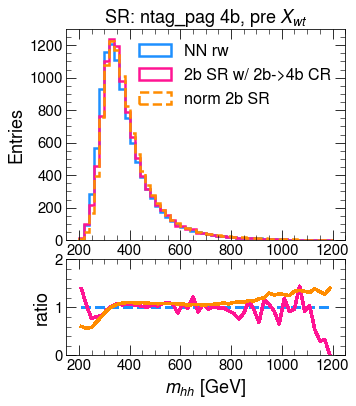

In [26]:
fig = plt.figure(figsize=(5,6))
gs = gridspec.GridSpec(3,1)
ax1 = fig.add_subplot(gs[:2,0])
ax2 = fig.add_subplot(gs[2,0],sharex=ax1)

nb,r = 50, (200,1200)

m_2b = (bdf_4b.ntag_pag==2)
m_4b = (bdf_4b.ntag_pag==4)
CR = (bdf_4b.kinematic_region==2)
SR = (bdf_4b.kinematic_region==0)

n_CR_4b = np.histogram(bdf_4b.loc[CR & m_4b,'m_hh'],nb,r)[0]
n_CR_2b = np.histogram(bdf_4b.loc[CR & m_2b,'m_hh'],nb,r)[0]
n_SR_2b = np.histogram(bdf_4b.loc[SR & m_2b,'m_hh'],nb,r)[0]

rw_SR,e,_ = ax1.hist(bdf_4b.loc[SR & m_2b,'m_hh'], nb,r, histtype='step',
                     lw=2.5, color='dodgerblue', label='NN rw',
                     weights=bdf_4b.loc[SR & m_2b,f'NN_d24_weight_bstrap_med_{yr}'])

xx = 0.5 * (e[:-1] + e[1:])
my_pred = n_SR_2b * n_CR_4b / n_CR_2b
ax1.hist(xx,nb,r,histtype='step',
         lw=2.5,color='deeppink',label='2b SR w/ 2b->4b CR',
         weights=my_pred)

norm_2b = n_SR_2b*np.sum(n_CR_4b) / np.sum(n_CR_2b)
ax1.hist(xx,nb,r,histtype='step',ls='--',
         lw=2.5,color='darkorange',label='norm 2b SR',
         weights=norm_2b)

ax2.set_xlabel('$m_{hh}$ [GeV]',fontsize=18)
ax1.set_ylabel('Entries',fontsize=18)
ax1.legend(loc='upper right',fontsize=16)
ax1.set_title('SR: ntag_pag 4b, pre $X_{wt}$')

ax2.plot(xx, np.ones_like(xx),color='dodgerblue',ls='--')
ax2.plot(xx, my_pred / rw_SR,color='deeppink')
ax2.plot(xx, norm_2b / rw_SR,color='darkorange')

ax2.set_ylabel('ratio',fontsize=18)
ax2.set_ylim(0,2)



Pink's a little noisier, but slightly better than orange.

(0.0, 2.0)

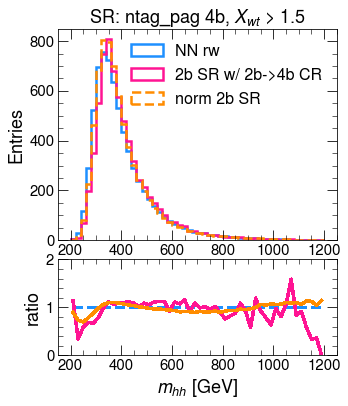

In [27]:
fig = plt.figure(figsize=(5,6))
gs = gridspec.GridSpec(3,1)
ax1 = fig.add_subplot(gs[:2,0])
ax2 = fig.add_subplot(gs[2,0],sharex=ax1)

nb,r = 50, (200,1200)

m_2b = (bdf_4b.ntag_pag==2)
m_4b = (bdf_4b.ntag_pag==4)
CR = (bdf_4b.kinematic_region==2) & (bdf_4b.X_wt > 1.5)
SR = (bdf_4b.kinematic_region==0) & (bdf_4b.X_wt > 1.5)

n_CR_4b = np.histogram(bdf_4b.loc[CR & m_4b,'m_hh'],nb,r)[0]
n_CR_2b = np.histogram(bdf_4b.loc[CR & m_2b,'m_hh'],nb,r)[0]
n_SR_2b = np.histogram(bdf_4b.loc[SR & m_2b,'m_hh'],nb,r)[0]

rw_SR,e,_ = ax1.hist(bdf_4b.loc[SR & m_2b,'m_hh'], nb,r, histtype='step',
                     lw=2.5, color='dodgerblue', label='NN rw',
                     weights=bdf_4b.loc[SR & m_2b,f'NN_d24_weight_bstrap_med_{yr}'])

xx = 0.5 * (e[:-1] + e[1:])
my_pred = n_SR_2b * n_CR_4b / n_CR_2b
ax1.hist(xx,nb,r,histtype='step',
         lw=2.5,color='deeppink',label='2b SR w/ 2b->4b CR',
         weights=my_pred)

norm_2b = n_SR_2b*np.sum(n_CR_4b) / np.sum(n_CR_2b)
ax1.hist(xx,nb,r,histtype='step',ls='--',
         lw=2.5,color='darkorange',label='norm 2b SR',
         weights=norm_2b)

ax2.set_xlabel('$m_{hh}$ [GeV]',fontsize=18)
ax1.set_ylabel('Entries',fontsize=18)
ax1.legend(loc='upper right',fontsize=16)
ax1.set_title('SR: ntag_pag 4b, $X_{wt}$ > 1.5')

ax2.plot(xx, np.ones_like(xx),color='dodgerblue',ls='--')
ax2.plot(xx, my_pred / rw_SR,color='deeppink')
ax2.plot(xx, norm_2b / rw_SR,color='darkorange')

ax2.set_ylabel('ratio',fontsize=18)
ax2.set_ylim(0,2)

Ok - the take away message (for me) is

<Figure size 432x288 with 0 Axes>

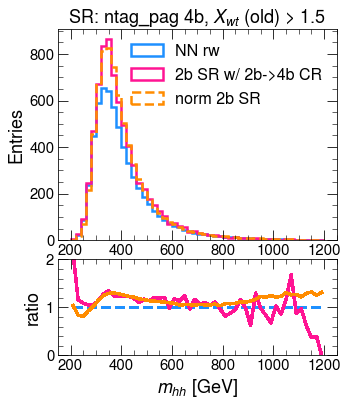

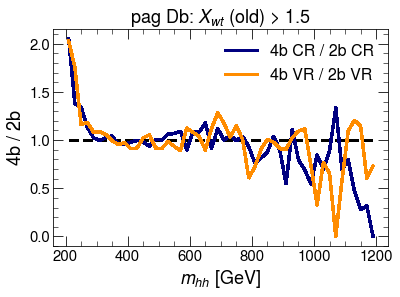

<Figure size 432x288 with 0 Axes>

In [28]:
fig = plt.figure(figsize=(5,6))
gs = gridspec.GridSpec(3,1)
ax1 = fig.add_subplot(gs[:2,0])
ax2 = fig.add_subplot(gs[2,0],sharex=ax1)

nb,r = 50, (200,1200)

m_2b = (bdf_4b.ntag_pag==2)
m_4b = (bdf_4b.ntag_pag==4)
CR = (bdf_4b.kinematic_region==2) & (bdf_4b.X_wt_old > 1.5)
VR = (bdf_4b.kinematic_region==1) & (bdf_4b.X_wt_old > 1.5)
SR = (bdf_4b.kinematic_region==0) & (bdf_4b.X_wt_old > 1.5)

n_CR_4b = np.histogram(bdf_4b.loc[CR & m_4b,'m_hh'],nb,r)[0]
n_CR_2b = np.histogram(bdf_4b.loc[CR & m_2b,'m_hh'],nb,r)[0]
n_SR_2b = np.histogram(bdf_4b.loc[SR & m_2b,'m_hh'],nb,r)[0]

rw_SR,e,_ = ax1.hist(bdf_4b.loc[SR & m_2b,'m_hh'], nb,r, histtype='step',
                     lw=2.5, color='dodgerblue', label='NN rw',
                     weights=bdf_4b.loc[SR & m_2b,f'NN_d24_weight_bstrap_med_{yr}'])

xx = 0.5 * (e[:-1] + e[1:])
my_pred = n_SR_2b * n_CR_4b / n_CR_2b
ax1.hist(xx,nb,r,histtype='step',
         lw=2.5,color='deeppink',label='2b SR w/ 2b->4b CR',
         weights=my_pred)

norm_2b = n_SR_2b*np.sum(n_CR_4b) / np.sum(n_CR_2b)
ax1.hist(xx,nb,r,histtype='step',ls='--',
         lw=2.5,color='darkorange',label='norm 2b SR',
         weights=norm_2b)

ax2.set_xlabel('$m_{hh}$ [GeV]',fontsize=18)
ax1.set_ylabel('Entries',fontsize=18)
ax1.legend(loc='upper right',fontsize=16)
ax1.set_title('SR: ntag_pag 4b, $X_{wt}$ (old) > 1.5')

ax2.plot(xx, np.ones_like(xx),color='dodgerblue',ls='--')
ax2.plot(xx, my_pred / rw_SR,color='deeppink')
ax2.plot(xx, norm_2b / rw_SR,color='darkorange')

ax2.set_ylabel('ratio',fontsize=18)
ax2.set_ylim(0,2)


plt.figure()
plt.plot(xx,np.ones_like(xx),'k--')

n_CR_4b = np.histogram(bdf_4b.loc[CR & m_4b,'m_hh'],nb,r,density=True)[0]
n_CR_2b = np.histogram(bdf_4b.loc[CR & m_2b,'m_hh'],nb,r,density=True)[0]
plt.plot(xx,n_CR_4b / n_CR_2b,color='navy',label='4b CR / 2b CR')

n_VR_4b = np.histogram(bdf_4b.loc[VR & m_4b,'m_hh'],nb,r,density=True)[0]
n_VR_2b = np.histogram(bdf_4b.loc[VR & m_2b,'m_hh'],nb,r,density=True)[0]
plt.plot(xx,n_VR_4b / n_VR_2b,color='darkorange',label='4b VR / 2b VR')

plt.xlabel('$m_{hh}$ [GeV]',fontsize=18)
plt.ylabel('4b / 2b',fontsize=18)
plt.legend(fontsize=16)
plt.title('pag Db: $X_{wt}$ (old) > 1.5')
plt.figure()

 My curiosity Q is, if we reweighted with `X_wt_old` before the cut, would then applying the cut give the same agreement as rw on X_wt and then applying that cut????? 

## Step 2: Significance scan <a name="sigScanOptCenters">
    
Ok, so this is sort of a rinse and repeat of what I have in the `bkg-regions-ntag-pag` and `HC-sort` notebooks but w/ the appropriate background estimate now.
    
These reweightings are with the sum jet $p_T$ sort for $\mathrm{\mathbb{P}}$, so I'll use the following SRs for for a first check:
- 4b: (125, 116) GeV
- 3b (loose and not loose): (125, 116) GeV
    
    
**Other additions from before:** Now post $X_{wt}$ and with trigger buckets.

In [29]:
x0,y0 = (120,110)
x1,y1 = (125,116)
x2,y2 = (125,114)

for df in [sdf,bdf_4b,bdf_3b1l,bdf_3bnl]:
    df[f'Xhh_120_110'] = df['Xhh']
    df[f'Xhh_{x1:.0f}_{y1:.0f}'] = getXhh(df.m_h1, df.m_h2, x1, y1)
    df[f'Xhh_{x2:.0f}_{y2:.0f}'] = getXhh(df.m_h1, df.m_h2, x2, y2)

In [30]:
z_dict = {}
Xhhs = np.arange(1,2.5,.1)

for bdf, tag, mi in zip([bdf_4b, bdf_3b1l, bdf_3bnl],['4b','3b1l','3bnl'],
                        [(sdf.ntag_pag==4),
                         (sdf.ntag_pag==3)&(sdf.minQ==2),
                         (sdf.ntag_pag==3)&(sdf.minQ==1)]):

    for x,y in zip([x0,x1,x2],[y0,y1,y2]):

        key = f'pag_{tag}_{x:.0f}_{y:.0f}'
        Xhh = f'Xhh_{x:.0f}_{y:.0f}'

        z_dict[key] = []

        for Xhh_cut in Xhhs:
            # smask 
            smask = (sdf[Xhh]< Xhh_cut) & (sdf.X_wt > 1.5) & mi

            # bmask
            bmask = (bdf[Xhh]< Xhh_cut) & (bdf.X_wt > 1.5) & (bdf.ntag_pag == 2) # 2 to apply the rw

            # histograms
            s = np.histogram(sdf.loc[smask,'m_hh'],nb,r,weights=sdf.loc[smask,'mc_sf'])[0]
            b = np.histogram(bdf.loc[bmask,'m_hh'],nb,r,weights=bdf.loc[bmask,w_2b])[0]

            z = np.nan_to_num(s / np.sqrt(b))
            
            z_dict[key].append(np.sqrt(np.sum(z**2)))


/gpfs/slac/atlas/fs1/d/rafaeltl/public/conda/miniconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in true_divide


In [31]:
z_dict.keys()

dict_keys(['pag_4b_120_110', 'pag_4b_125_116', 'pag_4b_125_114', 'pag_3b1l_120_110', 'pag_3b1l_125_116', 'pag_3b1l_125_114', 'pag_3bnl_120_110', 'pag_3bnl_125_116', 'pag_3bnl_125_114'])

In [32]:
figDir = f'figures/{physicsSample}-{prodTag}-5jets/preLN_lr_0p003/rw_cols'

In [36]:
psymb = '$\mathrm{\mathbb{P}}$'

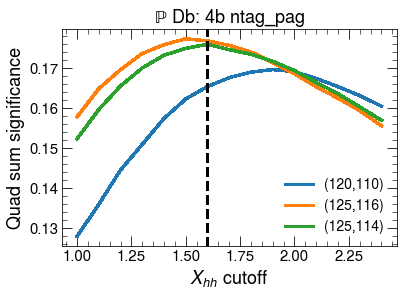

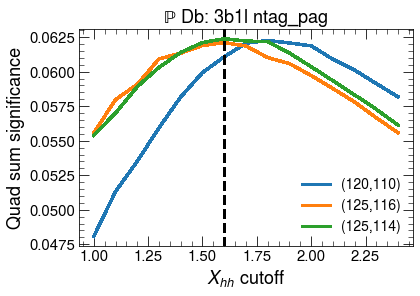

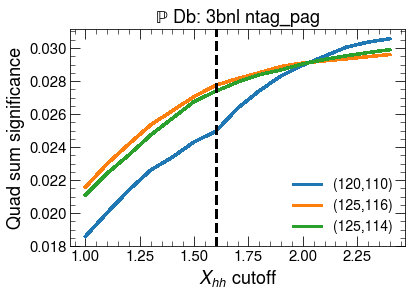

In [37]:
for tag in ['4b','3b1l','3bnl']:

    plt.figure()
    for x,y in zip([x0,x1,x2],[y0,y1,y2]):

        key = f'pag_{tag}_{x:.0f}_{y:.0f}'

        plt.plot(Xhhs,z_dict[key],label=f'({x:.0f},{y:.0f})')

    plt.xlabel('$X_{hh}$ cutoff',fontsize=18)
    plt.ylabel('Quad sum significance',fontsize=18)
    plt.legend()
    plt.title(f'{psymb} Db: {tag} ntag_pag')

    ylim = plt.ylim()
    plt.plot([1.6]*2,ylim,'k--')
    plt.ylim(ylim)

- The SR center optimized for 4b does best for 4b.
- Opt for 3b + 1 loose


Let's take the *orange* curve and compare the significances using cutoffs:
- $X_{hh} < 1.5$ for 4b
- $X_{hh} < 1.6$ for the 3b categories

In [21]:
Xhhs[5],Xhhs[6]

(1.5000000000000004, 1.6000000000000005)

In [22]:
z_4b   = z_dict[f'pag_4b_{x1:.0f}_{y1:.0f}'][5]
z_3b1l = z_dict[f'pag_3b1l_{x1:.0f}_{y1:.0f}'][6]
z_3bnl = z_dict[f'pag_3bnl_{x1:.0f}_{y1:.0f}'][6]

In [190]:
np.sqrt(z_4b**2 + z_3b1l**2) / z_4b

1.051462840798655

In [24]:
z_tot = np.sqrt(z_4b**2 + z_3b1l**2 + z_3bnl**2)
z_tot / z_4b

1.069223996747492

What about w/r.t. the "nominal" analysis?

In [25]:
z0 = z_dict[f'pag_4b_{x0:.0f}_{y0:.0f}'][6]
z_tot, z0

(0.18858738440799372, 0.16435456524963715)

In [26]:
z_tot / z0

1.1474423245959093

In [191]:
np.sqrt(z0**2 + z_dict[f'pag_3b1l_120_110'][6]**2) / z0

1.057177027274657

Alright! So we're looking at a 15% improvement *before* the angular categorization.

What did Todd have in his [3b $\mathrm{\mathbb{P}}$](https://indico.cern.ch/event/986955/contributions/4155451/attachments/2165136/3654019/hh4b_3bUpdate_17_12_20.pdf):

He saw the limit w/ systematics w/ my pag SM training w/ the jet $p_T$ sort went from (for the 2017 dataset) 18.8 $\rightarrow$ 17.2 (pre-$X_{wt}$), which is a 8-9% improvment. *Interesting.*

In [27]:
17.2/18.8

0.9148936170212765

Ok - I'm trying to understand how much improving the lowest purity category can help us...

In [28]:
z_tot = np.sqrt(z_4b**2 + z_3b1l**2 + (1.5*z_3bnl)**2)
z_tot / z_4b

1.09101891242593

**Conclusion:** I would need to improve the lowest $p_T$ category by 50% to have a visible impact on the 4b category by 2% (dayum lol)

## Step 3: With bkg errors <a name="sigBkgErr">
    
The reweighting has two different kinds of errrs:
- VR derived / CR derived
- bootstrap errors
      
As a sanity check, let's compare them really quickly for the 3 categories with the *nominal* $X_{hh}$ cut.

In [29]:
from postprocess import calc_bstrap

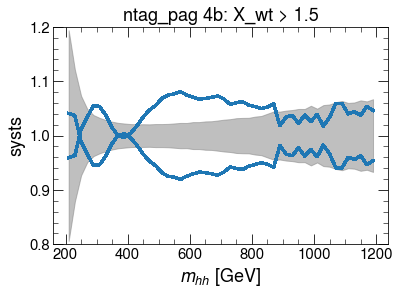

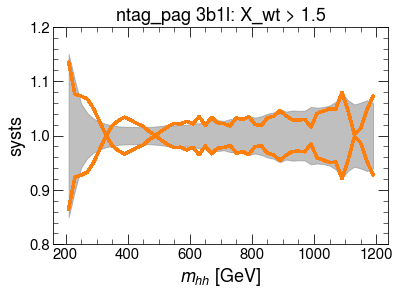

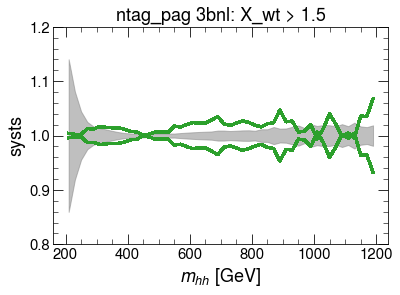

In [30]:
Xhh = 'Xhh'
Xhh_cut = 1.6

hists = {}
err_dict = {}



for bdf,f,tag,color,mi in zip([bdf_4b,bdf_3b1l,bdf_3bnl],[f_4b,f_3b1l,f_3bnl],
                              ['4b','3b1l','3bnl'],['C0','C1','C2'],
                              [(sdf.ntag_pag==4),(sdf.ntag_pag==3)&(sdf.minQ==2),
                               (sdf.ntag_pag==3)&(sdf.minQ==1)]):

    
    # smask 
    smask = (sdf[Xhh]< Xhh_cut) & (sdf.X_wt > 1.5) & mi
    s = np.histogram(sdf.loc[smask,'m_hh'],nb,r,weights=sdf.loc[smask,'mc_sf'])[0]
    
    bmask = (bdf[Xhh]< Xhh_cut) & (bdf.X_wt > 1.5) & (bdf.ntag_pag == 2) # 2 to apply the rw

    b    = np.histogram(bdf.loc[bmask,'m_hh'],nb,r,weights=bdf.loc[bmask,w_2b])[0]
    b_vr = np.histogram(bdf.loc[bmask,'m_hh'],nb,r,weights=bdf.loc[bmask,w_2b_VR])[0]
    
    norm     = f[f'NN_norm_bstrap_med_{yr}']._fVal
    norm_IQR = f[f'NN_norm_bstrap_IQR_{yr}']._fVal
    
    bstrap = calc_bstrap(bdf[bmask], 'm_hh', yr, norm, norm_IQR, nb, r)
    
    # Save
    hists[f's_{tag}'],    hists[f'b_{tag}']  = s, b
    hists[f'b_vr_{tag}'], hists[f'bs_{tag}'] = b_vr, bstrap
    
    plt.figure()
    err =( 2*b - b_vr)/ b

    err_dict[tag+'_vr'] = err
    
    plt.plot(xx,err,color=color,label='VR variation')
    plt.plot(xx,2-err,color=color)

    dbs = bstrap / b
    plt.fill_between(xx,1-dbs,1+dbs,color='grey',alpha=0.5,label='bootstrap')

    err_dict[tag+'_bs'] = dbs
    
    plt.ylabel('systs',fontsize=18)
    plt.xlabel('$m_{hh}$ [GeV]',fontsize=18)
    plt.title(f'ntag_pag {tag}: X_wt > 1.5')
    plt.ylim(0.8,1.2)
    
    #plt.plot(xx,np.ones_like(xx),'k--')
    

Ok - I *think* this makes sense.
- For 4b, in the region that *drives* out analysis sensitivity, the shape systematics *dominate*
- For 3b1l, our stats are *a lot* lower, so this *inflates* our bootstrap errors (now they're basically comparable to our shape systematic... damn!
- For 3bnl, the systematics seem the smallest of all, and perhaps this is b /c of 2 effects? 
    1. Our target stats are the *highest* in this category, so this explains why the bootstrap errors would go down.
    2. Perhaps 3b is more similar to the 2b distributions than 4b? (This is *easy* to check with a comparison of the $\chi^2$ metrics in the SR.)

(0.8, 1.2)

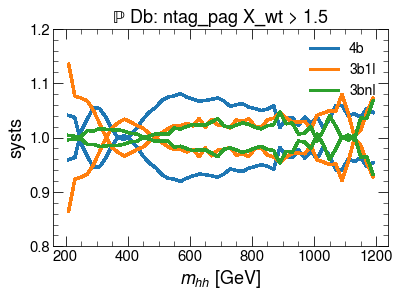

In [31]:
for i,tag in enumerate(['4b','3b1l','3bnl']):
    plt.plot(xx,err_dict[tag+'_vr'],color=f'C{i}',label=tag)
    plt.plot(xx,2-err_dict[tag+'_vr'],color=f'C{i}')
        
plt.ylabel('systs',fontsize=18)
plt.xlabel('$m_{hh}$ [GeV]',fontsize=18)
plt.title(f'{psymb} Db: ntag_pag X_wt > 1.5')
plt.legend()#(loc='lower right',fontsize=14)
plt.ylim(0.8,1.2)

(0.8, 1.2)

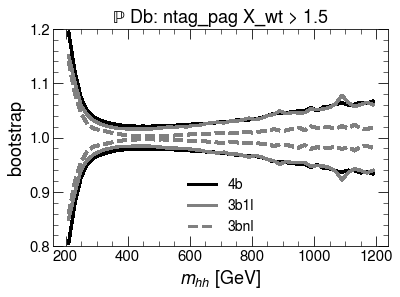

In [32]:
for tag,c,ls in zip(['4b','3b1l','3bnl'],['k','grey','grey'],['-','-','--']):

    dbs = err_dict[tag+'_bs']
    
    plt.plot(xx,1-dbs,color=c,ls=ls,label=tag)
    plt.plot(xx,1+dbs,color=c,ls=ls)

plt.ylabel('bootstrap',fontsize=18)
plt.xlabel('$m_{hh}$ [GeV]',fontsize=18)
plt.title(f'{psymb} Db: ntag_pag X_wt > 1.5')
plt.legend()
plt.ylim(0.8,1.2)

Ok - so this *would* help explain why Todd saw a larger relative improvement with the stats only limits.

Also, it's very interesting that the bootstrap errors are identical with the 4b and 3b1l categories, even though the 2b training stats are only 25% in the 3b1l category (and I think the target stats are smaller in the 3b+1loose category too????).

Anyways, this is helping us with the training message that we're *not* limited by the 2b statistics for the source distribution.


**But ok, let's put this together to with the significance now!!**


First test, with the nominal cut, what's the difference b/w adding the variation + bootstrap errrors *in quadrature* vs just using the bootstrap errors?

In [33]:
z_dict.keys()

dict_keys(['pag_4b_120_110', 'pag_4b_125_116', 'pag_4b_125_114', 'pag_3b1l_120_110', 'pag_3b1l_125_116', 'pag_3b1l_125_114', 'pag_3bnl_120_110', 'pag_3bnl_125_116', 'pag_3bnl_125_114'])

4b drop 0.8519922430418962
3b1l drop 0.9547317455772051
3bnl drop 0.9005188625104694


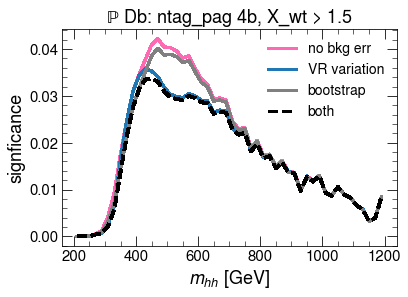

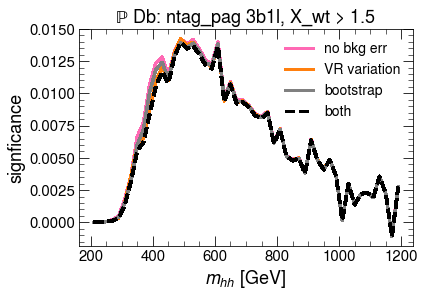

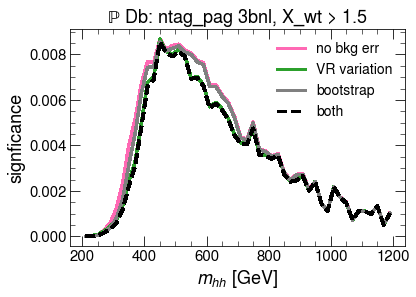

In [34]:
for i,tag in enumerate(['4b','3b1l','3bnl']):
    
    s,b,b_vr,bs = [hists[f'{k}_{tag}'] for k in ['s','b','b_vr','bs']]
    
    
    # Maybe it might be nice to overlay the significance plot?
    plt.figure()
    
    plt.plot(xx,s/np.sqrt(b), label='no bkg err', color='hotpink')
    
    for db,l,c,ls in zip([np.abs(b-b_vr),bs,np.sqrt((b-b_vr)**2 + bs**2)],
                         ['VR variation','bootstrap','both'],
                         [f'C{i}','grey','k'],['-','-','--']):
    
            plt.plot(xx, significance(s+b,b,db), label=l, color=c,ls=ls)
             
    plt.ylabel('signficance',fontsize=18)
    plt.xlabel('$m_{hh}$ [GeV]',fontsize=18)
    plt.title(f'{psymb} Db: ntag_pag {tag}, X_wt > 1.5')
    plt.legend()
     
    print(tag,'drop', np.sqrt(np.sum(significance(s+b,b,db)**2)) / z_dict[f'pag_{tag}_120_110'][6])
        

Since for almost *all* of these cases the black dashed line follows *nearly exactly* with the VR variation error line, it's fine to just use the VR variation for the subsequent metrics.

In [35]:
np.sqrt(np.sum(significance(s+b,b,bs)**2)) /np.sqrt(np.sum((s/np.sqrt(b))**2))

0.9785733136761168

In [36]:
np.sqrt(np.sum(significance(s+b,b,np.abs(b-b_vr))**2)) /np.sqrt(np.sum((s/np.sqrt(b))**2))

0.9123040061330979

In [37]:
err = np.sqrt((b-b_vr)**2 + bs**2)

np.sqrt(np.sum(significance(s+b,b,err)**2)) /np.sqrt(np.sum((s/np.sqrt(b))**2))

0.9005188625104694

In [38]:
z_err = {}

for bdf, tag, mi in zip([bdf_4b, bdf_3b1l, bdf_3bnl],['4b','3b1l','3bnl'],
                        [(sdf.ntag_pag==4),
                         (sdf.ntag_pag==3)&(sdf.minQ==2),
                         (sdf.ntag_pag==3)&(sdf.minQ==1)]):

    for x,y in zip([x0,x1,x2],[y0,y1,y2]):

        key = f'pag_{tag}_{x:.0f}_{y:.0f}'
        Xhh = f'Xhh_{x:.0f}_{y:.0f}'

        z_err[key] = []

        for Xhh_cut in Xhhs:
            # smask 
            smask = (sdf[Xhh]< Xhh_cut) & (sdf.X_wt > 1.5) & mi

            # bmask
            bmask = (bdf[Xhh]< Xhh_cut) & (bdf.X_wt > 1.5) & (bdf.ntag_pag == 2) # 2 to apply the rw

            # histograms
            s = np.histogram(sdf.loc[smask,'m_hh'],nb,r,weights=sdf.loc[smask,'mc_sf'])[0]
            b = np.histogram(bdf.loc[bmask,'m_hh'],nb,r,weights=bdf.loc[bmask,w_2b])[0]
            b_vr = np.histogram(bdf.loc[bmask,'m_hh'],nb,r,weights=bdf.loc[bmask,w_2b_VR])[0]
            
            z = np.nan_to_num(significance(s+b, b, np.abs(b-b_vr)))
            z_err[key].append(np.sqrt(np.sum(z**2)))

/gpfs/slac/atlas/fs1/d/nhartman/diHiggs4b/PAG-opt/postprocess.py:88: RuntimeWarning: invalid value encountered in sqrt
  return np.sign(n-b) * np.sqrt(z2)
/gpfs/slac/atlas/fs1/d/nhartman/diHiggs4b/PAG-opt/postprocess.py:84: RuntimeWarning: invalid value encountered in true_divide
  z2 = n * np.log( np.where( n==0, 1, (n*(b+db**2))/(b**2+n*db**2)) )
/gpfs/slac/atlas/fs1/d/nhartman/diHiggs4b/PAG-opt/postprocess.py:85: RuntimeWarning: invalid value encountered in true_divide
  z2 -= (b**2/db**2) * np.log(1 + (db**2 * (n-b))/(b*(b+db**2)))


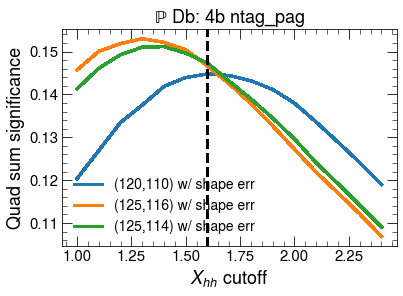

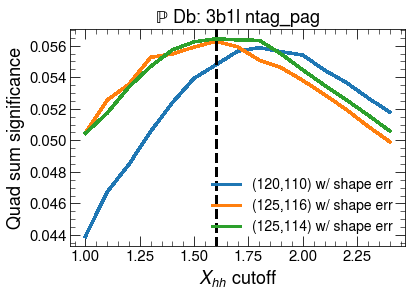

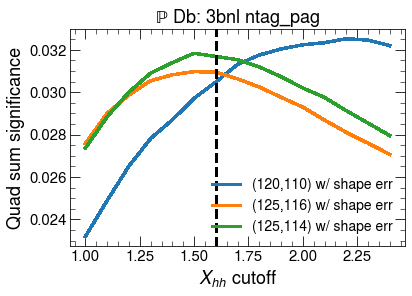

In [39]:
for tag in ['4b','3b1l','3bnl']:

    plt.figure()
    for i,x,y in zip(range(3),[x0,x1,x2],[y0,y1,y2]):

        key = f'pag_{tag}_{x:.0f}_{y:.0f}'

        #plt.plot(Xhhs, z_dict[key],f'C{i}',label=f'({x:.0f},{y:.0f}) stat only')
        plt.plot(Xhhs, z_err[key], f'C{i}',label=f'({x:.0f},{y:.0f}) w/ shape err')
        
        
    plt.xlabel('$X_{hh}$ cutoff',fontsize=18)
    plt.ylabel('Quad sum significance',fontsize=18)
    plt.legend()
    plt.title(f'{psymb} Db: {tag} ntag_pag')

    ylim = plt.ylim()
    plt.plot([1.6]*2,ylim,'k--')
    plt.ylim(ylim)

Ok - this is *super cool*...
- With systs, we event want to *narrow* the cutoff boundary (it seems like)
- 4b: optimal at 1.3, although 1.5 is reasonable for all of the choices.
- Now it's seeming p clear that for 3b + not loose the 3b optimized shape is doing better

In [40]:
Xhhs[3]

1.3000000000000003

In [41]:
s0 =  z_err[f'pag_4b_120_110'][3]

s_4b   = z_err[f'pag_4b_{x1:.0f}_{y1:.0f}'][3]
s_3b1l = z_err[f'pag_3b1l_{x1:.0f}_{y1:.0f}'][6]
s_3bnl = z_err[f'pag_3bnl_{x1:.0f}_{y1:.0f}'][5]

In [42]:
s_4b / s0

1.1124799251415447

In [ ]:
np.sqrt(s_4b**2 + s_3b1l**2) / s0

In [168]:
np.sqrt(s_4b**2 + s_3b1l**2) / s0

1.1853387342279786

In [265]:
np.sqrt(s_4b**2 + s_3b1l**2 + s_3bnl**2) / s0

1.2065364343400526

In [267]:
np.sqrt(s_4b**2 + s_3b1l**2 + (1.3*s_3bnl)**2) / s0

1.2209482878627151

In [198]:
np.sqrt(s0**2 + z_err[f'pag_3b1l_120_110'][6]**2 + + z_err[f'pag_3bnl_120_110'][6]**2)/ s0

1.0989924211488713

Ok - at this point, it seems like there are some pretty clear winners in terms of the significance, but one thing that Sean pointed out is it's worth while to check the systematics definitions for our *newly* optimized SR center to make sure that we're not just destroying our systematics rn.

/gpfs/slac/atlas/fs1/d/rafaeltl/public/conda/miniconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/gpfs/slac/atlas/fs1/d/rafaeltl/public/conda/miniconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in true_divide


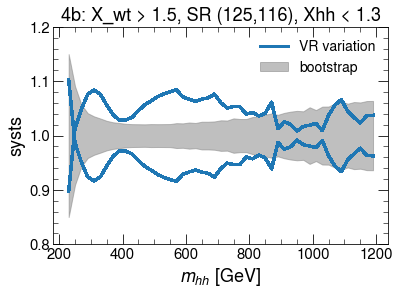

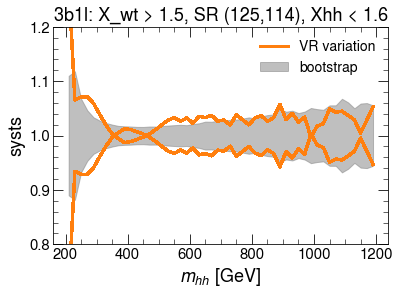

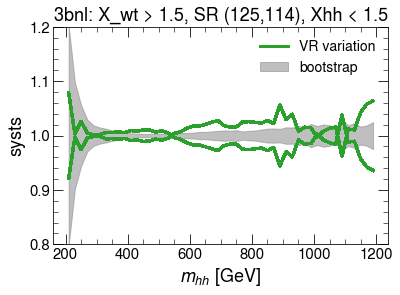

In [123]:
hists_opt = {}
err_dict_opt = {}

for bdf,f,tag,color,mi,sr,Xhh_cut in zip([bdf_4b,bdf_3b1l,bdf_3bnl],
                                          [f_4b,f_3b1l,f_3bnl],
                                          ['4b','3b1l','3bnl'],
                                          ['C0','C1','C2'],
                                          [(sdf.ntag_pag==4),
                                           (sdf.ntag_pag==3)&(sdf.minQ==2),
                                           (sdf.ntag_pag==3)&(sdf.minQ==1)],
                                          [(125,116),(125,114),(125,114)],
                                          [1.3,1.6,1.5]):

    x,y = sr
    Xhh = f'Xhh_{x:.0f}_{y:.0f}'
    
    # smask 
    smask = (sdf[Xhh]< Xhh_cut) & (sdf.X_wt > 1.5) & mi
    s = np.histogram(sdf.loc[smask,'m_hh'],nb,r,weights=sdf.loc[smask,'mc_sf'])[0]
    
    bmask = (bdf[Xhh]< Xhh_cut) & (bdf.X_wt > 1.5) & (bdf.ntag_pag == 2) # 2 to apply the rw

    b    = np.histogram(bdf.loc[bmask,'m_hh'],nb,r,weights=bdf.loc[bmask,w_2b])[0]
    b_vr = np.histogram(bdf.loc[bmask,'m_hh'],nb,r,weights=bdf.loc[bmask,w_2b_VR])[0]
    
    norm     = f[f'NN_norm_bstrap_med_{yr}']._fVal
    norm_IQR = f[f'NN_norm_bstrap_IQR_{yr}']._fVal
    
    bstrap = calc_bstrap(bdf[bmask], 'm_hh', yr, norm, norm_IQR, nb, r)
    
    # Save
    hists_opt[f's_{tag}'],    hists[f'b_{tag}']  = s, b
    hists_opt[f'b_vr_{tag}'], hists[f'bs_{tag}'] = b_vr, bstrap
    
    plt.figure()
    err =( 2*b - b_vr)/ b

    err_dict_opt[tag+'_vr'] = err
    
    plt.plot(xx,err,color=color,label='VR variation')
    plt.plot(xx,2-err,color=color)

    dbs = bstrap / b
    plt.fill_between(xx,1-dbs,1+dbs,color='grey',alpha=0.5,label='bootstrap')

    err_dict_opt[tag+'_bs'] = dbs
    
    plt.ylabel('systs',fontsize=18)
    plt.xlabel('$m_{hh}$ [GeV]',fontsize=18)
    plt.title(f'{tag}: X_wt > 1.5, SR ({x:.0f},{y:.0f}), Xhh < {Xhh_cut:.1f}')
    plt.ylim(0.8,1.2)
    plt.legend()
    #plt.plot(xx,np.ones_like(xx),'k--')
    

Cool! Ok, so I think what I want is 
- dashed line for old SR
- solid line for new SR

And then compare this same set of 3 plots.


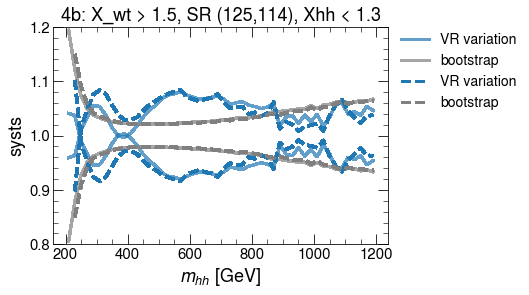

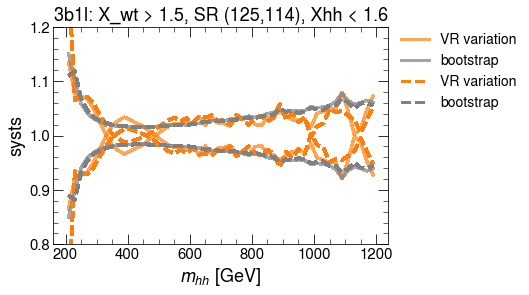

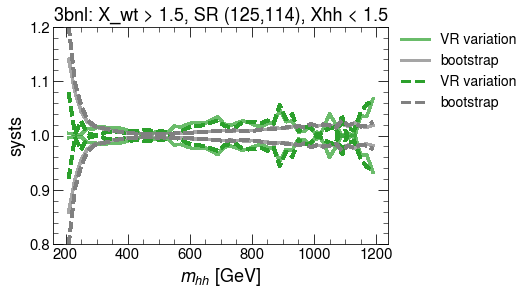

In [126]:
for tag,color,sr,Xhh_cut in zip(['4b','3b1l','3bnl'],['C0','C1','C2'],
                                [(125,116),(125,114),(125,114)],
                                [1.3,1.6,1.5]):

    plt.figure()
    
    for e_dict,ls,alpha in zip([err_dict,err_dict_opt],['-','--'],[.7,1]): 


        # Retrieve the histograms
        err, dbs = e_dict[tag+'_vr'], e_dict[tag+'_bs']
        
        plt.plot(xx,err,color,ls=ls,alpha=alpha,label='VR variation')
        plt.plot(xx,2-err,color,ls=ls,alpha=alpha)

        
        plt.plot(xx,1-dbs,'grey',ls=ls,alpha=alpha,label='bootstrap')
        plt.plot(xx,1+dbs,'grey',ls=ls,alpha=alpha)


    plt.ylabel('systs',fontsize=18)
    plt.xlabel('$m_{hh}$ [GeV]',fontsize=18)
    plt.legend(bbox_to_anchor=(1,1.03))
    plt.title(f'{tag}: X_wt > 1.5, SR ({x:.0f},{y:.0f}), Xhh < {Xhh_cut:.1f}')
    plt.ylim(0.8,1.2)



In [ ]:
# hists_opt[f's_{tag}'],    hists[f'b_{tag}']  = s, b
#     hists_opt[f'b_vr_{tag}'], hists[f'bs_{tag}'] = b_vr, bstrap
    

## Step 4: MDpT impact <a name="MDpT">
    
**Goal:** These were some cuts we had in the prev iteration of the analysis.

Since they weren't providing S vs B discriminatin in the 4b SR (given checks by *many* analyzers, we decided to drop them for 4b. But sicne these *new* categories have **lower purity**, it might be worth investigating these extra cuts for these regions as well.

**Step 1:** Let's make some vis plots!

Ok, so for 3b + not loose the SR center at (125, 114) GeV looked the best (and consistently across the mass spectrum), and the cutoff at $X_{hh} = 1.5$ was slightly better than the cutoff at $X_{hh} = 1.6$, but not by a lot, I think just changing the SR center is a reasonable place to start this check from.


I'm lifting some code from my [4b-Cut-Optimization](https://gitlab.cern.ch/hartman/dihiggs4b/-/blob/master/GraphNN/4b-Cut-Optimization.ipynb) notebook.

In [206]:
def plot_MDpT(df,w='mc_sf',nBins=30,histRange=[[200,1250],[0,400]],
              cmap='RdPu',text='',title='',figDir='',tag='',
              a_pT1=0.5,  b_pT1=-103,
              a_pT2=0.33, b_pT2=-73,
              labels=[],linestyles=[]
             ):
    '''
    Draw the 2d histogram plot of HC pT vs m_hh for the leading and subleading HC
    that we cut on for our MDR cuts.
    '''
    
    fig, axes = plt.subplots(1,2,figsize=(10,5))
    
    m4j = np.linspace(*histRange[0])
    
    for ax,col,ylabel,a,b,c in zip(axes,['lead_HC_pT','subl_HC_pT'],
                                   ['$p_T^{HC1}$','$p_T^{HC2}$'],
                                   [a_pT1,a_pT2],[b_pT1,b_pT2],
                                   ['rebeccapurple','navy']):
    
        n,xx,yy = np.histogram2d(df['m_hh'],df[col],nBins,histRange,weights=df[w])
        pcm = ax.pcolormesh(xx,yy,n.T, cmap=cmap)
        fig.colorbar(pcm, ax=ax)
        ax.set_xlabel('$m_{hh}$ [GeV]',fontsize=16)
        ax.set_ylabel(ylabel+' [GeV]',fontsize=16)
    
        # Overlay the proposed cuts
        if type(a) == list:
            for ai, bi, l, s in zip(a,b,labels,linestyles):
                ax.plot(m4j, ai * m4j + bi, c, label=l, linestyle=s)
            ax.legend(loc='lower right', fontsize=12)
        else:
            ax.plot(m4j, a * m4j + b, c)
        ax.set_ylim(*histRange[1])
    
    fig.suptitle(title,fontsize=16,va='center')
    plt.tight_layout()
    
    # Save the figure
#     if len(figDir) > 0:
#         plt.savefig(f'{figDir}/pT_hi_vs_m4j{tag}.pdf',bbox_inches='tight')
    
    plt.show()



In [ ]:
bdf_3bnl

In [173]:
# J sanity checking that I've already applied this cut
sdf.abs_deta_hh.max()

1.4999790199952507

In [194]:
for df in [sdf,bdf_4b,bdf_3b1l,bdf_3bnl]:
    m = df.pT_h1 > df.pT_h2
    df['lead_HC_pt'] = np.where(m, df.pT_h1,df.pT_h2)
    df['subl_HC_pt'] = np.where(m, df.pT_h2,df.pT_h1)

In [195]:
for c in bdf_3bnl.columns:
    print(c)

m_hh
MDpT
kinematic_region
m_h1
m_h2
ntag_pag
pT_h1
pT_h2
X_wt
X_wt_old
Xhh
abs_deta_hh
NN_d24_weight_bstrap_med_17
NN_d24_weight_bstrap_IQR_17
NN_d24_weight_VRderiv_bstrap_med_17
NN_d24_weight_VRderiv_bstrap_IQR_17
minQ
lead_HC_pt
subl_HC_pt
Xhh_120_110
Xhh_125_116
Xhh_125_114
lead_HC_pT
subl_HC_pT


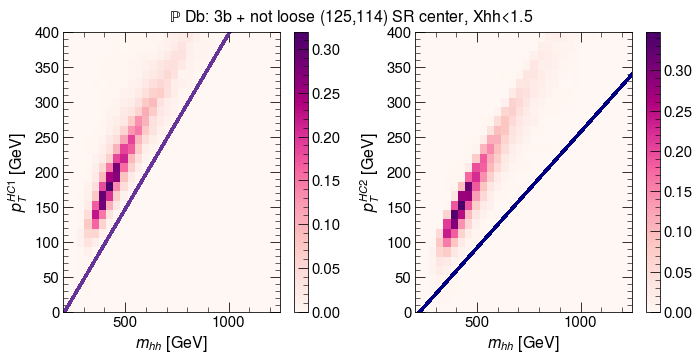

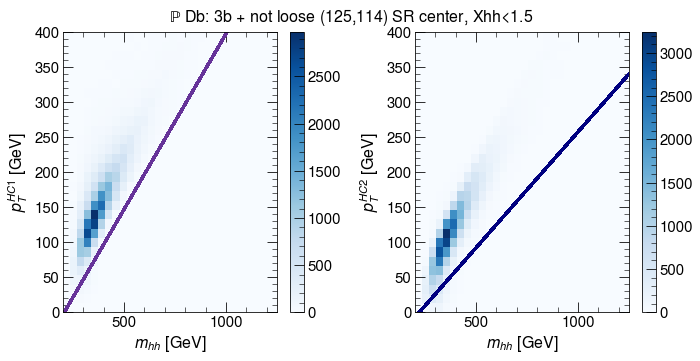

In [208]:
smask = (sdf.ntag_pag >=4) & (sdf.X_wt > 1.5) & (sdf.Xhh_125_114 < 1.5)
bmask = (bdf_3bnl.ntag_pag ==2) & (bdf_3bnl.X_wt > 1.5) & (bdf_3bnl.Xhh_125_114 < 1.5)

title = f'{psymb} Db: 3b + not loose ({x2},{y2}) SR center, Xhh<1.5'

plot_MDpT(sdf[smask],'mc_sf', cmap='RdPu',text='',title=title)
plot_MDpT(bdf_3bnl[bmask],w_2b, cmap='Blues',text='',title=title)

In [216]:
def proposeMDpTCuts(sig_df, col, nBins=30,histRange=[[200,1250],[0,400]],
                    WP=0.975, start=2, stop=12, color='rebeccapurple',
                    smText='',title='',figDir='',tag=''):

    n,xx,yy = np.histogram2d(sig_df['m_hh'],sig_df[col],nBins,histRange,
                             weights=sig_df['mc_sf'])

    mis = 0.5 * (xx[:-1]+xx[1:])
    ptis = 0.5 * (yy[:-1]+yy[1:])
    
    pt_cuts = []
    nevts = []
    for ni,mhh_min,mhh_max in zip(n,xx[:-1],xx[1:]):

        effs = np.add.accumulate(ni[::-1])/np.sum(ni)
        i_eff = np.argmin(np.abs(effs-WP))
        pt_cuts.append(yy[::-1][i_eff+1])
        mask = (sig_df['m_hh'] > mhh_min) & (sig_df['m_hh'] < mhh_max)
        nevts.append(np.sum(sig_df.loc[mask & (sig_df[col]>pt_cuts[-1]),'mc_sf']))
        #print(nevts[-1],np.sum(ni[::-1][:i_eff+1]),effs[i_eff]*np.sum(ni))

    # Do the fit
    a,b = np.polyfit(mis[start:stop],pt_cuts[start:stop],deg=1)
    
    fig, ax1 = plt.subplots()
    ax2 = ax1.twinx()

    # Color code the plots according to which ones are included in the fit
    ax1.scatter(mis[:start],pt_cuts[:start],color=color,alpha=0.5)
    ax1.scatter(mis[start:stop],pt_cuts[start:stop],color=color)
    ax1.scatter(mis[stop:],pt_cuts[stop:],color=color,alpha=0.5)
    ax2.scatter(mis,nevts,marker='^',color='grey')

    # Overlay the best fit line
    ax1.plot(mis,a*mis+b,'k--')
    
    ax1.set_ylim(0,histRange[1][1])
    
    sgn_b = '+' if (np.sign(b)==1) else '-'
    text = f'Best fit line:\n{a:.3f} * ' 
    text += '$m_{hh}$' 
    text += f' {sgn_b} {np.abs(b):.3f}'
    ax1.text(0.3,.95,text,va='top',ha='left',
             fontsize=12,transform=ax1.transAxes)

    ax1.set_xlabel('$m_{hh}$ [GeV]',fontsize=14)
    hci = '1' if col[:4]=='lead' else '2'
    ax1.set_ylabel('cut $p_T^{HC'+hci+'}$ for '+f'{WP*100}% eff',fontsize=14)
    ax2.set_ylabel('events passing this cut',fontsize=14)

    ax1.tick_params(axis='y', colors=color)
    ax1.yaxis.label.set_color(color)

    ax2.tick_params(axis='y', colors='grey')
    ax2.yaxis.label.set_color('grey')

    ax1.text(0,1,smText,ha='left',va='bottom',transform=ax1.transAxes)
    ax1.set_title(title,loc='left',fontsize=16)

    if len(figDir) > 0:
        plt.savefig(f'{figDir}/{col}_proposedMDpTCuts_{WP*100}%WP{tag}.pdf')
    
    plt.show()
    
    return a,b

In [219]:
np.sqrt(.95)

0.9746794344808963

/gpfs/slac/atlas/fs1/d/rafaeltl/public/conda/miniconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in true_divide


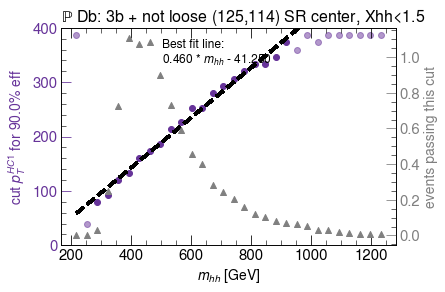

/gpfs/slac/atlas/fs1/d/rafaeltl/public/conda/miniconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in true_divide


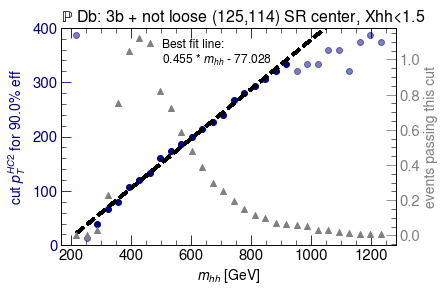

In [227]:
WP = .9
a_pT1,b_pT1 = proposeMDpTCuts(sdf[smask],'lead_HC_pt',title=title,
                              start=2,stop=21,WP=WP)#,figDir=f'figures/{sigSubDir}')
a_pT2,b_pT2 = proposeMDpTCuts(sdf[smask],'subl_HC_pt',title=title,color='navy',
                              start=2,stop=21,WP=WP)#,figDir=f'figures/{sigSubDir}')

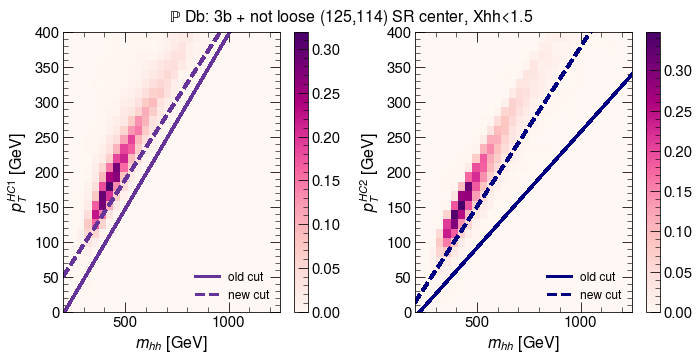

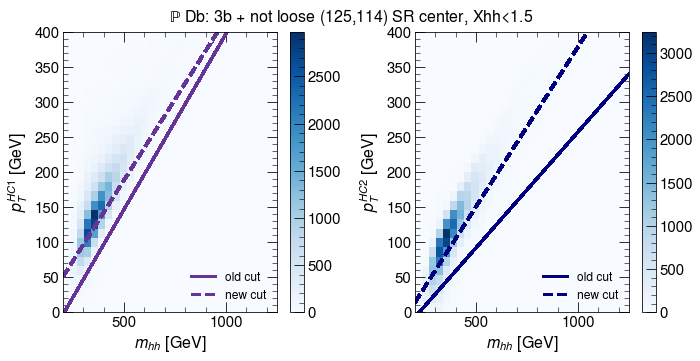

In [228]:
tag = f"_{WP*100}%WP"

plot_MDpT(sdf[smask],cmap='RdPu',
          title=title,
          a_pT1=[0.5,a_pT1],  b_pT1=[-103,b_pT1],
          a_pT2=[0.33,a_pT2], b_pT2=[-73,b_pT2],
          labels=['old cut','new cut'],linestyles=['-','--'])#,
          #figDir=f'figures/{sigSubDir}',tag=tag) 

plot_MDpT(bdf_3bnl[bmask],w_2b,cmap='Blues',title=title,
          a_pT1=[0.5,a_pT1],  b_pT1=[-103,b_pT1],
          a_pT2=[0.33,a_pT2], b_pT2=[-73,b_pT2],
          labels=['old cut','new cut'],linestyles=['-','--'])#,
          #figDir=f'figures/{bkgSubDir}',tag=tag) 

Ok - awesome! So visually we can we the impact not that great ... i.e, we're not cutting *massively* into the blob. (Although maybe this is a bit more impactful for $p_T^{HC1}$ than $p_T^{HC2}$.)

**Compare the $p_T^{HC}$ distributions before and after this newly proposed cut** 

Ok, let's do a plot with *two scales* to visualize the S and B *separately*, but also the impact of this cut.

In [231]:
for df in [sdf,bdf_4b,bdf_3b1l,bdf_3bnl]:
    
    
    lead_pT_cut = a_pT1 * df.m_hh + b_pT1
    subl_pT_cut = a_pT2  * df.m_hh + b_pT2

    df['MDpT_new'] = (df.lead_HC_pt > lead_pT_cut) & (df.subl_HC_pt > subl_pT_cut) 


Other cols that might be nice to look at as well:
- absCosThetaStar
- dR_1, dR_2
- dRjj_1, dRjj_2
- pt_hh

/gpfs/slac/atlas/fs1/d/rafaeltl/public/conda/miniconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in true_divide
/gpfs/slac/atlas/fs1/d/rafaeltl/public/conda/miniconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in true_divide
/gpfs/slac/atlas/fs1/d/rafaeltl/public/conda/miniconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in true_divide
/gpfs/slac/atlas/fs1/d/rafaeltl/public/conda/miniconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in true_divide
/gpfs/slac/atlas/fs1/d/rafaeltl/public/conda/miniconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in true_divide


m_hh
  nom: 0.05490159624890195
  MDpT: 0.057298171189448285
lead_HC_pT
  nom: 0.0498191910598351
  MDpT: 0.05271583439784616
subl_HC_pT
  nom: 0.05716117952616768
  MDpT: 0.05739319717155167
abs_deta_hh
  nom: 0.040099612270589585
  MDpT: 0.04260693415759317


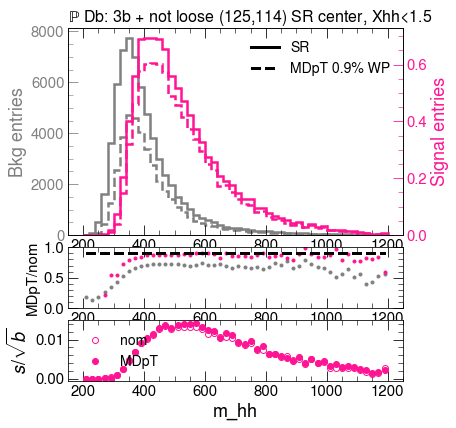

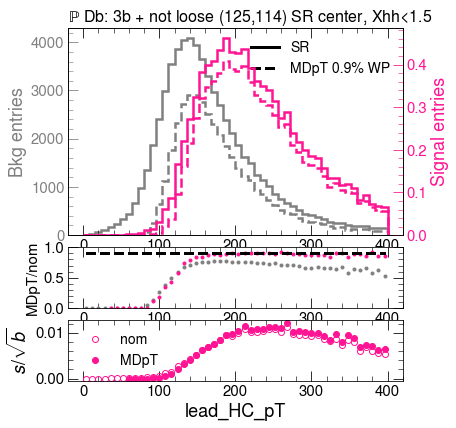

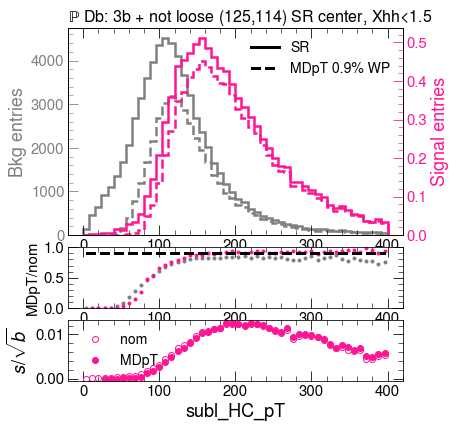

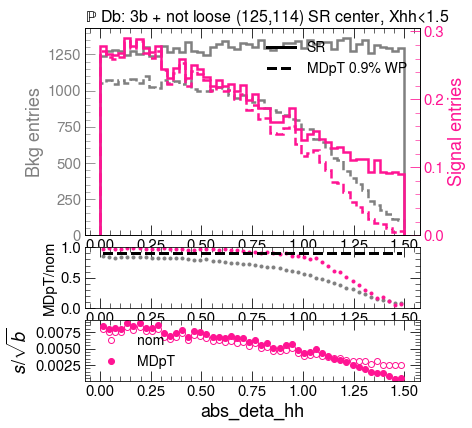

In [253]:
for c,ri in zip(['m_hh','lead_HC_pT','subl_HC_pT','abs_deta_hh'],#,'absCosThetaStar'],
                [r,(0,400),(0,400),(0,1.5),(0,1)]):

    fig = plt.figure(figsize=(6,6.5))
    gs = gridspec.GridSpec(5,1)
    ax1 = fig.add_subplot(gs[:3,0])
    ax2 = ax1.twinx()
    ax3 = fig.add_subplot(gs[3,0],sharex=ax1)
    ax4 = fig.add_subplot(gs[4,0],sharex=ax1)
    
    hists = {}
    for df,ax,w,color,m,yl in zip([bdf_3bnl,sdf],[ax1,ax2],[w_2b,'mc_sf'],['grey','deeppink'],
                                  [bmask,smask],['Bkg','Signal']):


        n0,e,_ = ax.hist(df.loc[m,c],nb,ri,
                          weights=df.loc[m,w],
                          histtype='step',lw=2.5,color=color)
        n1,_,_ = ax.hist(df.loc[m & df.MDpT_new,c],nb,ri,
                          histtype='step',lw=2.5,color=color,ls='--',
                          weights=df.loc[m & df.MDpT_new,w])

        xi = 0.5 * (e[1:] + e[:-1])

        # ratio
        ax3.plot(xi,n1/n0,lw=0,marker='.',color=color)

        # Beautification
        ax.set_ylabel(f'{yl} entries',fontsize=18, color=color)
        ax.tick_params(axis='y',which='both', colors=color)

        hists[yl] = [n0,n1]
        
        
    ax3.set_ylabel('MDpT/nom')
    ax3.set_ylim(0,1)
    ax3.plot(xi,WP*np.ones_like(xi),'k--')

    print(c)
    # Add s / sqrt(b)
    for si,bi,fs,l in zip(hists['Signal'],hists['Bkg'],['none','full'],['nom','MDpT']):
        zi = si/np.sqrt(bi)
        ax4.plot(xi,zi,color,lw=0,marker='o',fillstyle=fs,label=l)
        
        print(f'  {l}:',np.sqrt(np.sum(np.nan_to_num(zi)**2)))
        
    ax4.set_xlabel(c,fontsize=18)
    ax4.set_ylabel('$s/\sqrt{b}$',fontsize=18)
    ax4.legend()

    ax1.plot([],[],'k',ls='-',label='SR')
    ax1.plot([],[],'k',ls='--',label=f'MDpT {WP}% WP')
    ax1.legend()
    
#     ax1.legend(loc='upper left')
#     ax2.legend(loc='upper right')
    ax1.set_title(title,loc='left',fontsize=16)

OK, this is *not* a new conclusion here, MDpT *kills* our high $|\Delta \eta_{hh}|$ contribution.

The part I *did* find interesting tho was that the way that we *killed* the background was even reduced at our high purity central `abs_deta_hh` region, which implies this *might* be orthogonal to additional angular categorization?

**Compare the significances**

I added a $3^{rd}$ subpanel on the plot, and these are the summed significances for each of the 1d variables.

- m_hh
  - nom: 0.05490159624890195
  - MDpT: 0.057298171189448285
- lead_HC_pT
  - nom: 0.0498191910598351
  - MDpT: 0.05271583439784616
- subl_HC_pT
  - nom: 0.05716117952616768
  - MDpT: 0.05739319717155167
- abs_deta_hh
  - nom: 0.040099612270589585
  - MDpT: 0.04260693415759317

In [254]:
# mhh
0.057298171189448285/ 0.05490159624890195

1.043652190542534

In [255]:
# pt h1
0.05271583439784616 / 0.0498191910598351

1.0581431226880433

In [257]:
# pt h2
.05739319717155167 / 0.05716117952616768

1.0040590073071844

In [256]:
0.04260693415759317 / 0.040099612270589585

1.0625273349299325

Another open Q: Is the modelling ok if I train *before* an MDpT cut and evaluate after??

(This is a fair Q haha, but I think I'll save it for another nb lol.)

**Hmmmmmm - should I keep playing w/ cuts here, or toss this forward into limits yet??**

Not sure atm.

If I *am* categorizing in an angular variable as well... should try to find a way to incorporate this in the opt too???


Other cuts that *might* help:
- dR_2 == min(dRjj_h1, dRjj_j2)
- max_prob (?)
- Toss events where ntag_pag != ntag?? 

## Step 5: Angular categorization <a name="deta">
    
The last "cut" that we have in the analysis is the $|\Delta \eta_{hh}|$ < 1.5 cut, but instead of tightening it - probably the name of the game is to see if we get a bigger *relative* improvement by adding in $|\cos \Theta^*|$ categories.

**Plan:** Let's run through this w/ a stats only and then w/ syst categorization.

Probably can do it just in one loop tho???

I should prob redo the Xhh cut opt here as well then haha.

In [96]:
?rainbow_text

/gpfs/slac/atlas/fs1/d/rafaeltl/public/conda/miniconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:60: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations


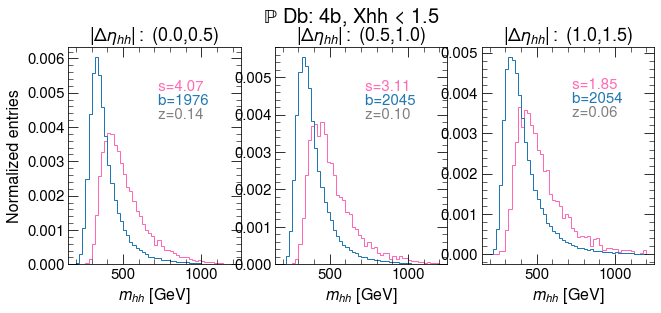

/gpfs/slac/atlas/fs1/d/nhartman/diHiggs4b/PAG-opt/postprocess.py:88: RuntimeWarning: invalid value encountered in sqrt
  return np.sign(n-b) * np.sqrt(z2)
/gpfs/slac/atlas/fs1/d/rafaeltl/public/conda/miniconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:60: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations


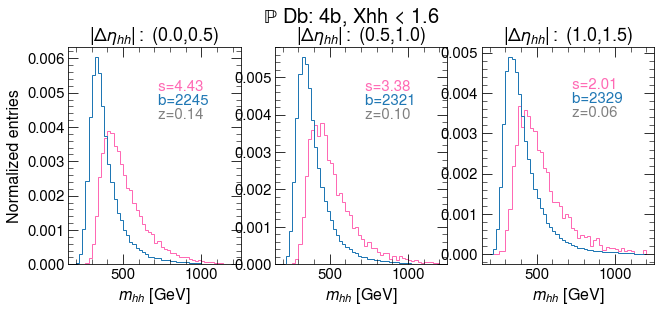

/gpfs/slac/atlas/fs1/d/nhartman/diHiggs4b/PAG-opt/postprocess.py:88: RuntimeWarning: invalid value encountered in sqrt
  return np.sign(n-b) * np.sqrt(z2)
/gpfs/slac/atlas/fs1/d/rafaeltl/public/conda/miniconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in true_divide
/gpfs/slac/atlas/fs1/d/nhartman/diHiggs4b/PAG-opt/postprocess.py:84: RuntimeWarning: invalid value encountered in true_divide
  z2 = n * np.log( np.where( n==0, 1, (n*(b+db**2))/(b**2+n*db**2)) )
/gpfs/slac/atlas/fs1/d/nhartman/diHiggs4b/PAG-opt/postprocess.py:85: RuntimeWarning: invalid value encountered in true_divide
  z2 -= (b**2/db**2) * np.log(1 + (db**2 * (n-b))/(b*(b+db**2)))
/gpfs/slac/atlas/fs1/d/rafaeltl/public/conda/miniconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:60: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations


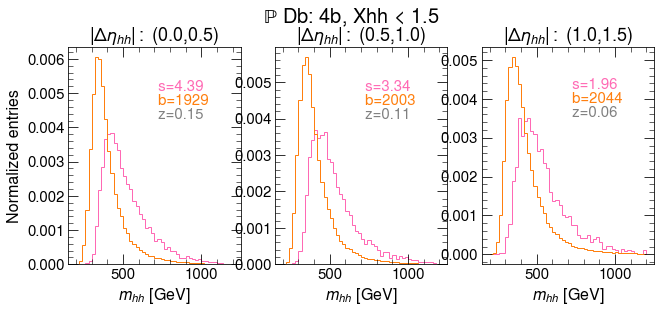

/gpfs/slac/atlas/fs1/d/nhartman/diHiggs4b/PAG-opt/postprocess.py:84: RuntimeWarning: invalid value encountered in true_divide
  z2 = n * np.log( np.where( n==0, 1, (n*(b+db**2))/(b**2+n*db**2)) )
/gpfs/slac/atlas/fs1/d/nhartman/diHiggs4b/PAG-opt/postprocess.py:85: RuntimeWarning: invalid value encountered in true_divide
  z2 -= (b**2/db**2) * np.log(1 + (db**2 * (n-b))/(b*(b+db**2)))
/gpfs/slac/atlas/fs1/d/nhartman/diHiggs4b/PAG-opt/postprocess.py:88: RuntimeWarning: invalid value encountered in sqrt
  return np.sign(n-b) * np.sqrt(z2)
/gpfs/slac/atlas/fs1/d/rafaeltl/public/conda/miniconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in true_divide
/gpfs/slac/atlas/fs1/d/rafaeltl/public/conda/miniconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:60: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations


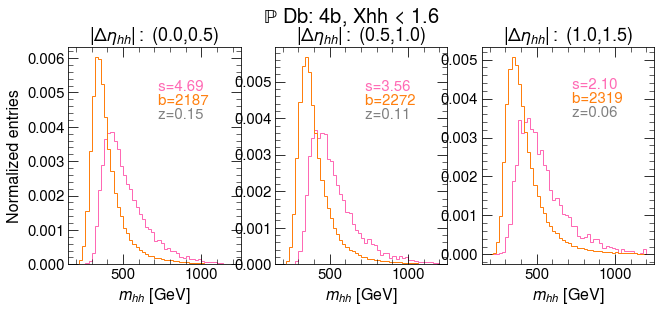

/gpfs/slac/atlas/fs1/d/nhartman/diHiggs4b/PAG-opt/postprocess.py:84: RuntimeWarning: invalid value encountered in true_divide
  z2 = n * np.log( np.where( n==0, 1, (n*(b+db**2))/(b**2+n*db**2)) )
/gpfs/slac/atlas/fs1/d/nhartman/diHiggs4b/PAG-opt/postprocess.py:85: RuntimeWarning: invalid value encountered in true_divide
  z2 -= (b**2/db**2) * np.log(1 + (db**2 * (n-b))/(b*(b+db**2)))
/gpfs/slac/atlas/fs1/d/nhartman/diHiggs4b/PAG-opt/postprocess.py:88: RuntimeWarning: invalid value encountered in sqrt
  return np.sign(n-b) * np.sqrt(z2)
/gpfs/slac/atlas/fs1/d/rafaeltl/public/conda/miniconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in true_divide
/gpfs/slac/atlas/fs1/d/rafaeltl/public/conda/miniconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:60: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations


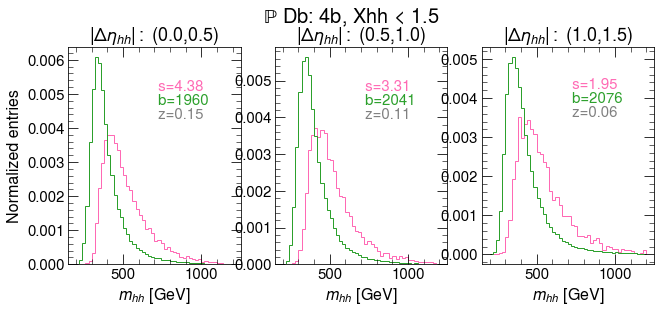

/gpfs/slac/atlas/fs1/d/nhartman/diHiggs4b/PAG-opt/postprocess.py:88: RuntimeWarning: invalid value encountered in sqrt
  return np.sign(n-b) * np.sqrt(z2)
/gpfs/slac/atlas/fs1/d/rafaeltl/public/conda/miniconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:60: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations


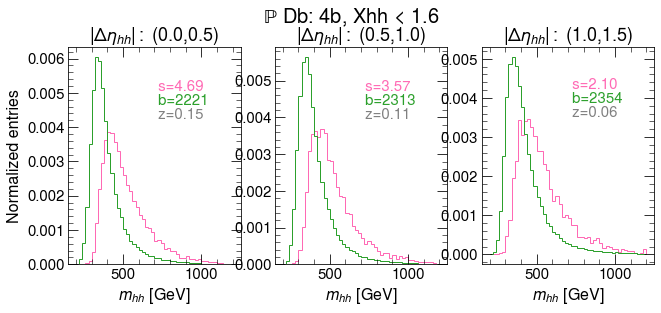

/gpfs/slac/atlas/fs1/d/nhartman/diHiggs4b/PAG-opt/postprocess.py:88: RuntimeWarning: invalid value encountered in sqrt
  return np.sign(n-b) * np.sqrt(z2)
/gpfs/slac/atlas/fs1/d/rafaeltl/public/conda/miniconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:35: RuntimeWarning: divide by zero encountered in true_divide
/gpfs/slac/atlas/fs1/d/rafaeltl/public/conda/miniconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in true_divide
/gpfs/slac/atlas/fs1/d/nhartman/diHiggs4b/PAG-opt/postprocess.py:84: RuntimeWarning: invalid value encountered in true_divide
  z2 = n * np.log( np.where( n==0, 1, (n*(b+db**2))/(b**2+n*db**2)) )
/gpfs/slac/atlas/fs1/d/nhartman/diHiggs4b/PAG-opt/postprocess.py:85: RuntimeWarning: invalid value encountered in true_divide
  z2 -= (b**2/db**2) * np.log(1 + (db**2 * (n-b))/(b*(b+db**2)))
/gpfs/slac/atlas/fs1/d/rafaeltl/public/conda/miniconda3/envs/py3/lib/python3.7/site-packages/ipykernel_la

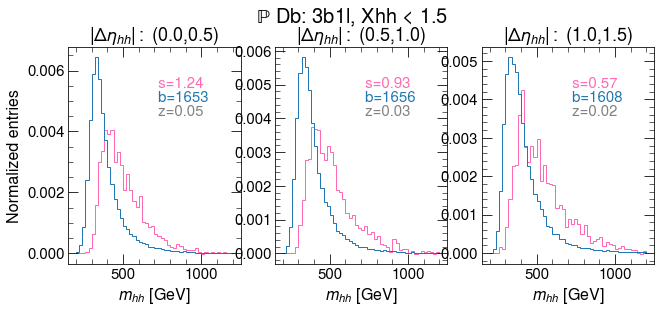

/gpfs/slac/atlas/fs1/d/nhartman/diHiggs4b/PAG-opt/postprocess.py:88: RuntimeWarning: invalid value encountered in sqrt
  return np.sign(n-b) * np.sqrt(z2)
/gpfs/slac/atlas/fs1/d/rafaeltl/public/conda/miniconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:60: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations


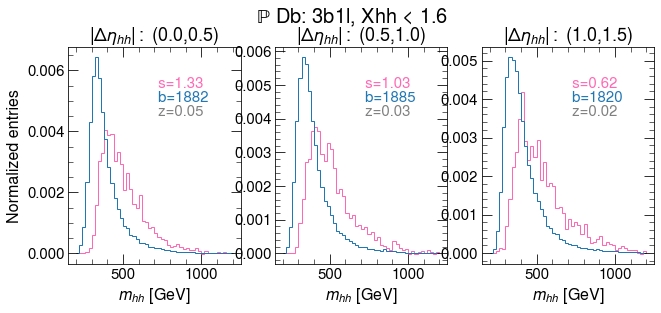

/gpfs/slac/atlas/fs1/d/nhartman/diHiggs4b/PAG-opt/postprocess.py:88: RuntimeWarning: invalid value encountered in sqrt
  return np.sign(n-b) * np.sqrt(z2)
/gpfs/slac/atlas/fs1/d/rafaeltl/public/conda/miniconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:35: RuntimeWarning: divide by zero encountered in true_divide
/gpfs/slac/atlas/fs1/d/rafaeltl/public/conda/miniconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in true_divide
/gpfs/slac/atlas/fs1/d/nhartman/diHiggs4b/PAG-opt/postprocess.py:84: RuntimeWarning: invalid value encountered in true_divide
  z2 = n * np.log( np.where( n==0, 1, (n*(b+db**2))/(b**2+n*db**2)) )
/gpfs/slac/atlas/fs1/d/nhartman/diHiggs4b/PAG-opt/postprocess.py:85: RuntimeWarning: invalid value encountered in true_divide
  z2 -= (b**2/db**2) * np.log(1 + (db**2 * (n-b))/(b*(b+db**2)))
/gpfs/slac/atlas/fs1/d/rafaeltl/public/conda/miniconda3/envs/py3/lib/python3.7/site-packages/ipykernel_la

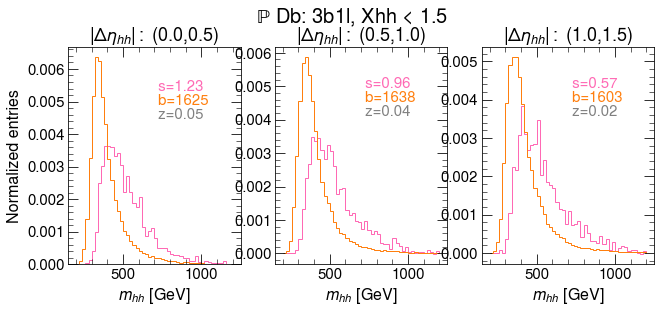

/gpfs/slac/atlas/fs1/d/nhartman/diHiggs4b/PAG-opt/postprocess.py:84: RuntimeWarning: invalid value encountered in true_divide
  z2 = n * np.log( np.where( n==0, 1, (n*(b+db**2))/(b**2+n*db**2)) )
/gpfs/slac/atlas/fs1/d/nhartman/diHiggs4b/PAG-opt/postprocess.py:85: RuntimeWarning: invalid value encountered in true_divide
  z2 -= (b**2/db**2) * np.log(1 + (db**2 * (n-b))/(b*(b+db**2)))
/gpfs/slac/atlas/fs1/d/nhartman/diHiggs4b/PAG-opt/postprocess.py:88: RuntimeWarning: invalid value encountered in sqrt
  return np.sign(n-b) * np.sqrt(z2)
/gpfs/slac/atlas/fs1/d/rafaeltl/public/conda/miniconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in true_divide
/gpfs/slac/atlas/fs1/d/rafaeltl/public/conda/miniconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:60: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations


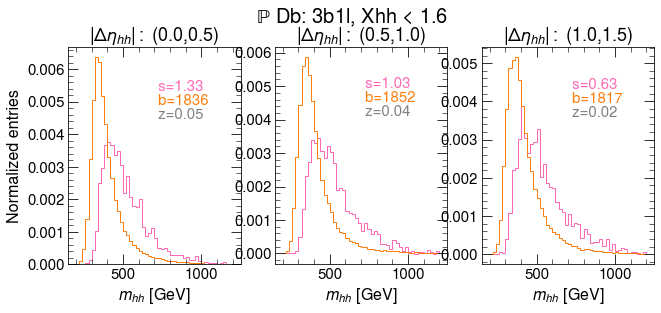

/gpfs/slac/atlas/fs1/d/nhartman/diHiggs4b/PAG-opt/postprocess.py:84: RuntimeWarning: invalid value encountered in true_divide
  z2 = n * np.log( np.where( n==0, 1, (n*(b+db**2))/(b**2+n*db**2)) )
/gpfs/slac/atlas/fs1/d/nhartman/diHiggs4b/PAG-opt/postprocess.py:85: RuntimeWarning: invalid value encountered in true_divide
  z2 -= (b**2/db**2) * np.log(1 + (db**2 * (n-b))/(b*(b+db**2)))
/gpfs/slac/atlas/fs1/d/nhartman/diHiggs4b/PAG-opt/postprocess.py:88: RuntimeWarning: invalid value encountered in sqrt
  return np.sign(n-b) * np.sqrt(z2)
/gpfs/slac/atlas/fs1/d/rafaeltl/public/conda/miniconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in true_divide
/gpfs/slac/atlas/fs1/d/rafaeltl/public/conda/miniconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:35: RuntimeWarning: divide by zero encountered in true_divide
/gpfs/slac/atlas/fs1/d/rafaeltl/public/conda/miniconda3/envs/py3/lib/python3.7/site-packages/ipykernel_la

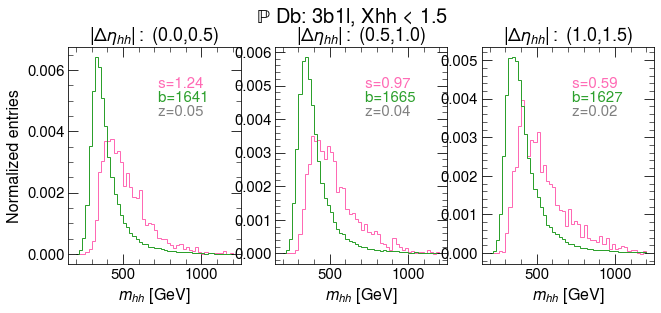

/gpfs/slac/atlas/fs1/d/nhartman/diHiggs4b/PAG-opt/postprocess.py:84: RuntimeWarning: invalid value encountered in true_divide
  z2 = n * np.log( np.where( n==0, 1, (n*(b+db**2))/(b**2+n*db**2)) )
/gpfs/slac/atlas/fs1/d/nhartman/diHiggs4b/PAG-opt/postprocess.py:85: RuntimeWarning: invalid value encountered in true_divide
  z2 -= (b**2/db**2) * np.log(1 + (db**2 * (n-b))/(b*(b+db**2)))
/gpfs/slac/atlas/fs1/d/nhartman/diHiggs4b/PAG-opt/postprocess.py:88: RuntimeWarning: invalid value encountered in sqrt
  return np.sign(n-b) * np.sqrt(z2)
/gpfs/slac/atlas/fs1/d/rafaeltl/public/conda/miniconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in true_divide
/gpfs/slac/atlas/fs1/d/rafaeltl/public/conda/miniconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:60: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations


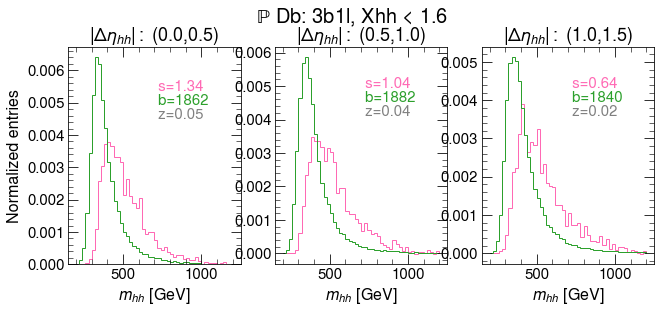

/gpfs/slac/atlas/fs1/d/nhartman/diHiggs4b/PAG-opt/postprocess.py:84: RuntimeWarning: invalid value encountered in true_divide
  z2 = n * np.log( np.where( n==0, 1, (n*(b+db**2))/(b**2+n*db**2)) )
/gpfs/slac/atlas/fs1/d/nhartman/diHiggs4b/PAG-opt/postprocess.py:85: RuntimeWarning: invalid value encountered in true_divide
  z2 -= (b**2/db**2) * np.log(1 + (db**2 * (n-b))/(b*(b+db**2)))
/gpfs/slac/atlas/fs1/d/nhartman/diHiggs4b/PAG-opt/postprocess.py:88: RuntimeWarning: invalid value encountered in sqrt
  return np.sign(n-b) * np.sqrt(z2)
/gpfs/slac/atlas/fs1/d/rafaeltl/public/conda/miniconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in true_divide
/gpfs/slac/atlas/fs1/d/rafaeltl/public/conda/miniconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:60: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations


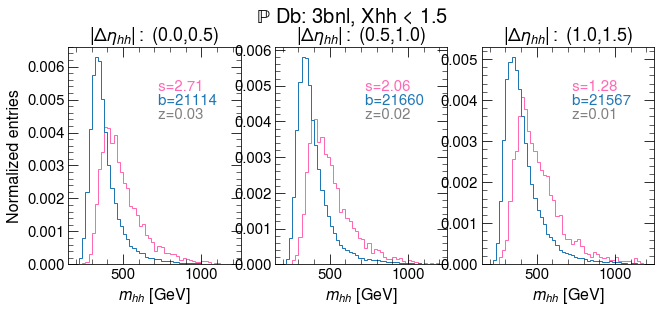

/gpfs/slac/atlas/fs1/d/nhartman/diHiggs4b/PAG-opt/postprocess.py:88: RuntimeWarning: invalid value encountered in sqrt
  return np.sign(n-b) * np.sqrt(z2)
/gpfs/slac/atlas/fs1/d/rafaeltl/public/conda/miniconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:60: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations


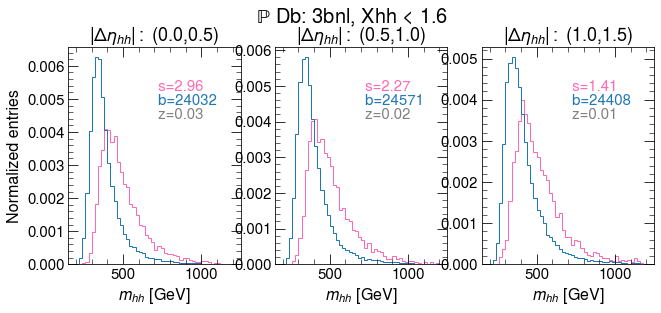

/gpfs/slac/atlas/fs1/d/nhartman/diHiggs4b/PAG-opt/postprocess.py:88: RuntimeWarning: invalid value encountered in sqrt
  return np.sign(n-b) * np.sqrt(z2)
/gpfs/slac/atlas/fs1/d/rafaeltl/public/conda/miniconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in true_divide
/gpfs/slac/atlas/fs1/d/nhartman/diHiggs4b/PAG-opt/postprocess.py:84: RuntimeWarning: invalid value encountered in true_divide
  z2 = n * np.log( np.where( n==0, 1, (n*(b+db**2))/(b**2+n*db**2)) )
/gpfs/slac/atlas/fs1/d/nhartman/diHiggs4b/PAG-opt/postprocess.py:85: RuntimeWarning: invalid value encountered in true_divide
  z2 -= (b**2/db**2) * np.log(1 + (db**2 * (n-b))/(b*(b+db**2)))
/gpfs/slac/atlas/fs1/d/rafaeltl/public/conda/miniconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:60: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations


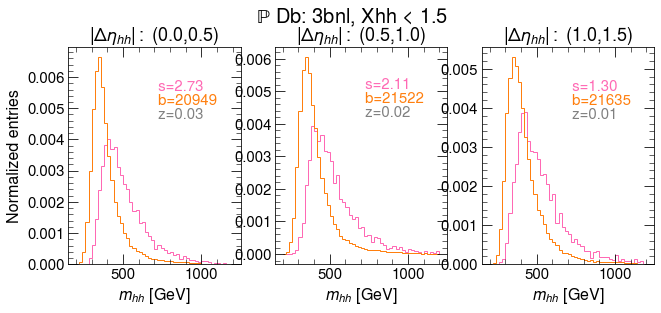

/gpfs/slac/atlas/fs1/d/nhartman/diHiggs4b/PAG-opt/postprocess.py:84: RuntimeWarning: invalid value encountered in true_divide
  z2 = n * np.log( np.where( n==0, 1, (n*(b+db**2))/(b**2+n*db**2)) )
/gpfs/slac/atlas/fs1/d/nhartman/diHiggs4b/PAG-opt/postprocess.py:85: RuntimeWarning: invalid value encountered in true_divide
  z2 -= (b**2/db**2) * np.log(1 + (db**2 * (n-b))/(b*(b+db**2)))
/gpfs/slac/atlas/fs1/d/rafaeltl/public/conda/miniconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in true_divide
/gpfs/slac/atlas/fs1/d/rafaeltl/public/conda/miniconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:60: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations


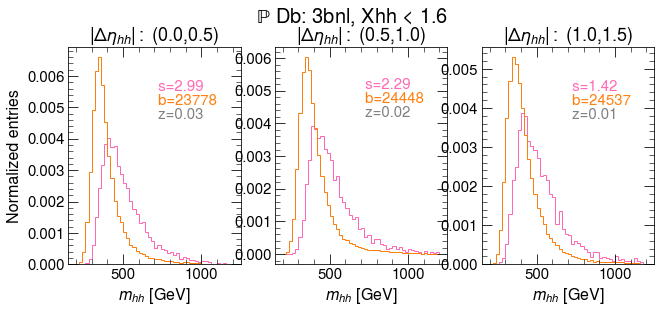

/gpfs/slac/atlas/fs1/d/nhartman/diHiggs4b/PAG-opt/postprocess.py:84: RuntimeWarning: invalid value encountered in true_divide
  z2 = n * np.log( np.where( n==0, 1, (n*(b+db**2))/(b**2+n*db**2)) )
/gpfs/slac/atlas/fs1/d/nhartman/diHiggs4b/PAG-opt/postprocess.py:85: RuntimeWarning: invalid value encountered in true_divide
  z2 -= (b**2/db**2) * np.log(1 + (db**2 * (n-b))/(b*(b+db**2)))
/gpfs/slac/atlas/fs1/d/rafaeltl/public/conda/miniconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in true_divide
/gpfs/slac/atlas/fs1/d/nhartman/diHiggs4b/PAG-opt/postprocess.py:88: RuntimeWarning: invalid value encountered in sqrt
  return np.sign(n-b) * np.sqrt(z2)
/gpfs/slac/atlas/fs1/d/rafaeltl/public/conda/miniconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:60: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations


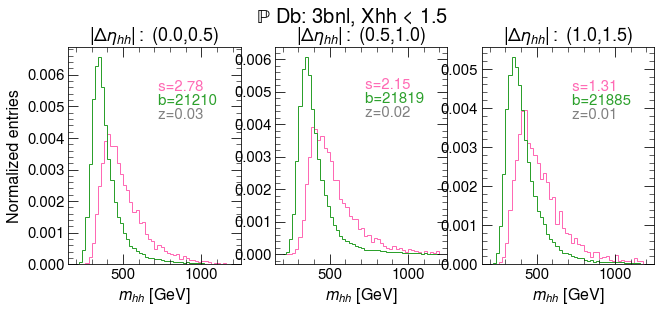

/gpfs/slac/atlas/fs1/d/nhartman/diHiggs4b/PAG-opt/postprocess.py:84: RuntimeWarning: invalid value encountered in true_divide
  z2 = n * np.log( np.where( n==0, 1, (n*(b+db**2))/(b**2+n*db**2)) )
/gpfs/slac/atlas/fs1/d/nhartman/diHiggs4b/PAG-opt/postprocess.py:85: RuntimeWarning: invalid value encountered in true_divide
  z2 -= (b**2/db**2) * np.log(1 + (db**2 * (n-b))/(b*(b+db**2)))
/gpfs/slac/atlas/fs1/d/nhartman/diHiggs4b/PAG-opt/postprocess.py:88: RuntimeWarning: invalid value encountered in sqrt
  return np.sign(n-b) * np.sqrt(z2)
/gpfs/slac/atlas/fs1/d/rafaeltl/public/conda/miniconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in true_divide
/gpfs/slac/atlas/fs1/d/rafaeltl/public/conda/miniconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:60: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations


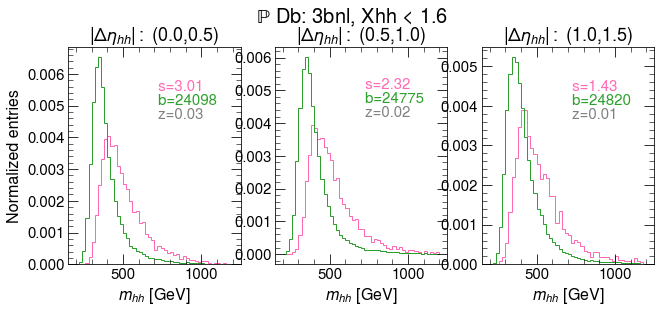

/gpfs/slac/atlas/fs1/d/nhartman/diHiggs4b/PAG-opt/postprocess.py:84: RuntimeWarning: invalid value encountered in true_divide
  z2 = n * np.log( np.where( n==0, 1, (n*(b+db**2))/(b**2+n*db**2)) )
/gpfs/slac/atlas/fs1/d/nhartman/diHiggs4b/PAG-opt/postprocess.py:85: RuntimeWarning: invalid value encountered in true_divide
  z2 -= (b**2/db**2) * np.log(1 + (db**2 * (n-b))/(b*(b+db**2)))
/gpfs/slac/atlas/fs1/d/nhartman/diHiggs4b/PAG-opt/postprocess.py:88: RuntimeWarning: invalid value encountered in sqrt
  return np.sign(n-b) * np.sqrt(z2)


In [105]:
cat_z = {}

neta_bins = 3

for bdf, tag, mi in zip([bdf_4b, bdf_3b1l, bdf_3bnl],['4b','3b1l','3bnl'],
                        [(sdf.ntag_pag==4),
                         (sdf.ntag_pag==3)&(sdf.minQ==2),
                         (sdf.ntag_pag==3)&(sdf.minQ==1)]):

    if tag == '3bnl' and Xhh_cut==1.4: break
    
    for i,x,y in zip(range(3),[x0,x1,x2],[y0,y1,y2]):

        key = f'pag_{tag}_{x:.0f}_{y:.0f}'
        Xhh = f'Xhh_{x:.0f}_{y:.0f}'

        cat_z[key+'_stat'],cat_z[key+'_err'] = [],[]

        for Xhh_cut in Xhhs:
            # smask 
            smask = (sdf[Xhh]< Xhh_cut) & (sdf.X_wt > 1.5) & mi

            # bmask
            bmask = (bdf[Xhh]< Xhh_cut) & (bdf.X_wt > 1.5) & (bdf.ntag_pag == 2) # 2 to apply the rw

            # histograms
            s,_,ey = np.histogram2d(*sdf.loc[smask,['m_hh','abs_deta_hh']].values.T,
                                    [nb,neta_bins],[r,(0,1.5)],weights=sdf.loc[smask,'mc_sf'])
            b      = np.histogram2d(*bdf.loc[bmask,['m_hh','abs_deta_hh']].values.T,
                                    [nb,neta_bins],[r,(0,1.5)],weights=bdf.loc[bmask,w_2b])[0]
            b_vr   = np.histogram2d(*bdf.loc[bmask,['m_hh','abs_deta_hh']].values.T,
                                    [nb,neta_bins],[r,(0,1.5)],weights=bdf.loc[bmask,w_2b_VR])[0]
            
            # stat only
            z = np.where( b==0, 0, s / np.sqrt(b) )
            #print(z)
            cat_z[key+'_stat'].append(np.sqrt(np.sum(z**2)))
            
            if (Xhh_cut > 1.45) and (Xhh_cut < 1.65):
                
                fig,axes = plt.subplots(1,neta_bins,figsize=(3.5*neta_bins,4))
                for axi,si,bi,zi,emin,emax in zip(axes,s.T,b.T,z.T,ey[:-1],ey[1:]):

                    axi.hist(xx,nb,r,color='hotpink',weights=si,histtype='step',density=True)
                    axi.hist(xx,nb,r,color=f'C{i}',weights=bi,histtype='step',density=True)

                    axi.set_xlabel('$m_{hh}$ [GeV]',fontsize=16)
                    axi.set_title('$|\Delta \eta_{hh}|: $ '+f'({emin:.1f},{emax:.1f})')

                    s_cat,b_cat,z_tot = np.sum(si),np.sum(bi),np.sqrt(np.sum(zi**2))
                    ls = [f's={s_cat:.2f}',f'b={b_cat:.0f}',f'z={z_tot:.2f}']
                    lc = ['hotpink',f'C{i}','grey']
                    
                    xloc,yloc = 700, 0.8 * axi.get_ylim()[1]
                    rainbow_text(xloc,yloc, ls,lc, yoffset=1,ax=axi)
                    
                axes[0].set_ylabel('Normalized entries',fontsize=16)

                fig.suptitle(f'{psymb} Db: {tag}, Xhh < {Xhh_cut:.1f}',fontsize=20,va='center')
                plt.tight_layout()
    
                plt.show()
                
                #break
             
            # w/ shape syst
            z = np.nan_to_num(significance(s+b, b, np.abs(b-b_vr)))
            cat_z[key+'_err'].append(np.sqrt(np.sum(z**2)))
    
        #break
    #break


Sweet - the bkg is pretty *stable* across these categories

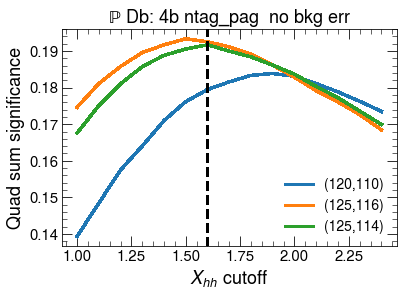

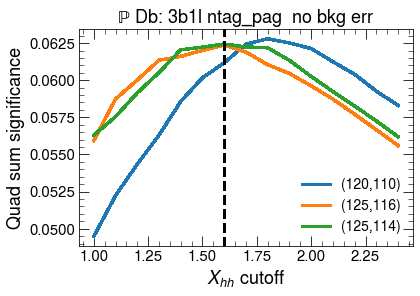

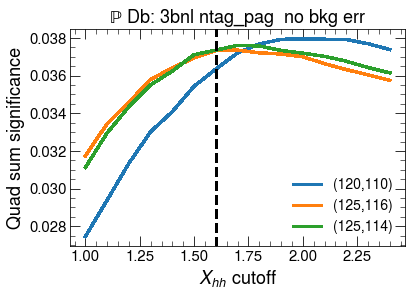

In [106]:
for tag in ['4b','3b1l','3bnl']:

    plt.figure()
    for i,x,y in zip(range(3),[x0,x1,x2],[y0,y1,y2]):

        key = f'pag_{tag}_{x:.0f}_{y:.0f}'

        plt.plot(Xhhs, cat_z[key+'_stat'], f'C{i}',label=f'({x:.0f},{y:.0f})')
        
        
    plt.xlabel('$X_{hh}$ cutoff',fontsize=18)
    plt.ylabel('Quad sum significance',fontsize=18)
    plt.legend()
    plt.title(f'{psymb} Db: {tag} ntag_pag  no bkg err')

    ylim = plt.ylim()
    plt.plot([1.6]*2,ylim,'k--')
    plt.ylim(ylim)

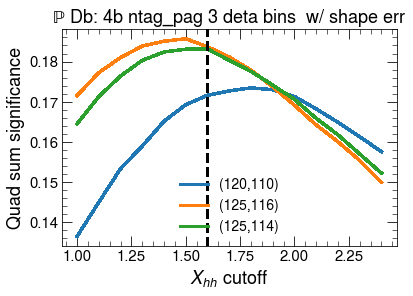

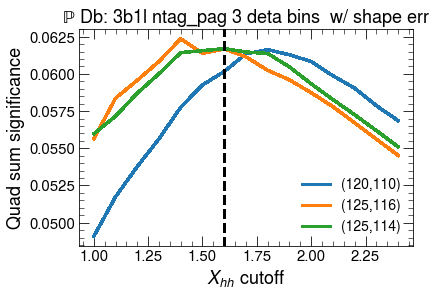

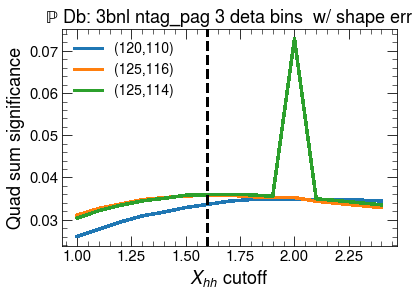

In [107]:
for tag in ['4b','3b1l','3bnl']:

    plt.figure()
    for i,x,y in zip(range(3),[x0,x1,x2],[y0,y1,y2]):

        key = f'pag_{tag}_{x:.0f}_{y:.0f}'

        #plt.plot(Xhhs, z_dict[key],f'C{i}',label=f'({x:.0f},{y:.0f}) stat only')
        plt.plot(Xhhs, cat_z[key+'_err'], f'C{i}',label=f'({x:.0f},{y:.0f})')
        
        
    plt.xlabel('$X_{hh}$ cutoff',fontsize=18)
    plt.ylabel('Quad sum significance',fontsize=18)
    plt.legend()
    plt.title(f'{psymb} Db: {tag} ntag_pag {neta_bins} deta bins  w/ shape err')

    ylim = plt.ylim()
    plt.plot([1.6]*2,ylim,'k--')
    plt.ylim(ylim)

In [108]:
cat_z.keys()

dict_keys(['pag_4b_120_110_stat', 'pag_4b_120_110_err', 'pag_4b_125_116_stat', 'pag_4b_125_116_err', 'pag_4b_125_114_stat', 'pag_4b_125_114_err', 'pag_3b1l_120_110_stat', 'pag_3b1l_120_110_err', 'pag_3b1l_125_116_stat', 'pag_3b1l_125_116_err', 'pag_3b1l_125_114_stat', 'pag_3b1l_125_114_err', 'pag_3bnl_120_110_stat', 'pag_3bnl_120_110_err', 'pag_3bnl_125_116_stat', 'pag_3bnl_125_116_err', 'pag_3bnl_125_114_stat', 'pag_3bnl_125_114_err'])

In [115]:
sc_4b   = cat_z['pag_4b_125_116_stat'][5]
sc_3b1l = cat_z['pag_3b1l_125_116_stat'][6]
sc_3bnl = cat_z['pag_3bnl_125_116_stat'][6]

In [117]:
sc_4b / z0, sc_4b / z_4b

(1.1766177767965142, 1.0964106299578644)

In [118]:
np.sqrt(np.sum(sc_4b**2 + sc_3b1l**2 + sc_3bnl**2)) / z0

1.2569838229411252

In [109]:
cat_4b   = cat_z['pag_4b_125_116_err'][5]
cat_3b1l = cat_z['pag_3b1l_125_116_err'][6]
cat_3bnl = cat_z['pag_3bnl_125_116_err'][6]

In [110]:
cat_4b/s_4b, cat_4b/s0

(1.2135961496893461, 1.3501013537584707)

In [111]:
cat_4b, cat_3b1l, cat_3bnl**2

(0.1856805880593854, 0.0616794898587022, 0.0012831669736991624)

In [112]:
np.sqrt(cat_4b**2 + cat_3b1l**2 + cat_3bnl**2)

0.19890904259235698

In [113]:
np.sqrt(cat_4b**2 + cat_3b1l**2 + cat_3bnl**2) / s_4b

1.3000564612132435

In [114]:
np.sqrt(cat_4b**2 + cat_3b1l**2 + cat_3bnl**2) / s0

1.4462867146502905

**Do we trust these results?**

Plan: Let's try to make some diagnostic plots in looking at the size of the systematics for the 3 deta categories 

In [138]:
hists2d = {}
errs2d = {}

for bdf,f,tag,color,mi,sr_new,opt_cut in zip([bdf_4b,bdf_3b1l,bdf_3bnl],
                                          [f_4b,f_3b1l,f_3bnl],
                                          ['4b','3b1l','3bnl'],
                                          ['C0','C1','C2'],
                                          [(sdf.ntag_pag==4),
                                           (sdf.ntag_pag==3)&(sdf.minQ==2),
                                           (sdf.ntag_pag==3)&(sdf.minQ==1)],
                                          [(125,116),(125,114),(125,114)],
                                          [1.5,1.6,1.6]):

    
    for sr,Xhh_cut,sid in zip([(120,110),sr_new],[1.6,opt_cut],['_old','_new']):
    
        x,y = sr
        Xhh = f'Xhh_{x:.0f}_{y:.0f}'

        # smask 
        smask = (sdf[Xhh]< Xhh_cut) & (sdf.X_wt > 1.5) & mi
        s = np.histogram2d(*sdf.loc[smask,['m_hh','abs_deta_hh']].values.T,
                           [nb,neta_bins], [r,(0,1.5)], weights=sdf.loc[smask,'mc_sf'])[0]

        bmask = (bdf[Xhh]< Xhh_cut) & (bdf.X_wt > 1.5) & (bdf.ntag_pag == 2) # 2 to apply the rw

        b    = np.histogram2d(*bdf.loc[bmask,['m_hh','abs_deta_hh']].values.T,
                              [nb,neta_bins], [r,(0,1.5)], weights=bdf.loc[bmask,w_2b])[0]
        b_vr = np.histogram2d(*bdf.loc[bmask,['m_hh','abs_deta_hh']].values.T,
                              [nb,neta_bins], [r,(0,1.5)], weights=bdf.loc[bmask,w_2b_VR])[0]

        norm     = f[f'NN_norm_bstrap_med_{yr}']._fVal
        norm_IQR = f[f'NN_norm_bstrap_IQR_{yr}']._fVal

        bstrap = []
        for emin,emax in zip(ey[:-1],ey[1:]):
        
            bsi = calc_bstrap(bdf[bmask & (bdf.abs_deta_hh > emin) & (bdf.abs_deta_hh < emax)], 
                              'm_hh', yr, norm, norm_IQR, nb, r)
            bstrap.append(bsi)
        bstrap = np.column_stack(bstrap)
        
        # Save hists
        hists2d[f's_{tag}{sid}'], hists2d[f'b_{tag}{sid}']  = s, b
        hists2d[f'b_vr_{tag}{sid}'], hists2d[f'bs_{tag}{sid}'] = b_vr, bstrap
        
        
        err =( 2*b - b_vr)/ b
        dbs = bstrap / b
        
        errs2d[f'{tag}_vr{sid}'] = err
        errs2d[f'{tag}_bs{sid}'] = dbs
         


/gpfs/slac/atlas/fs1/d/rafaeltl/public/conda/miniconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide
/gpfs/slac/atlas/fs1/d/rafaeltl/public/conda/miniconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:49: RuntimeWarning: invalid value encountered in true_divide


Coool - first let's viz the systematic variation!

In [135]:
errs2d.keys()

dict_keys(['4b_vr_old', '4b_vr_new', '3b1l_vr_old', '3b1l_vr_new', '3bnl_vr_old', '3bnl_vr_new'])

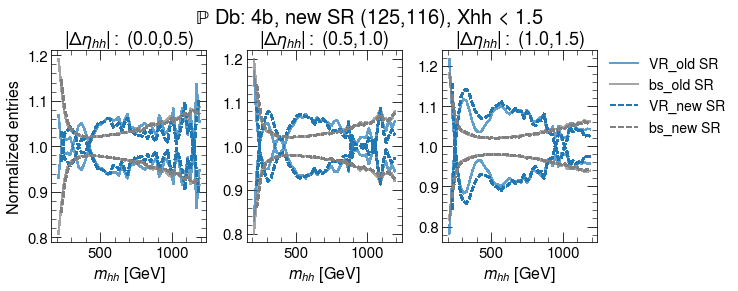

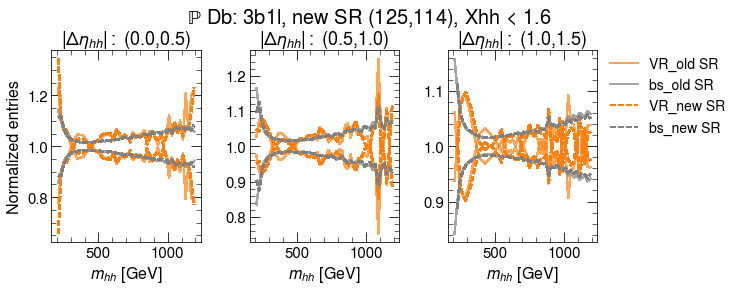

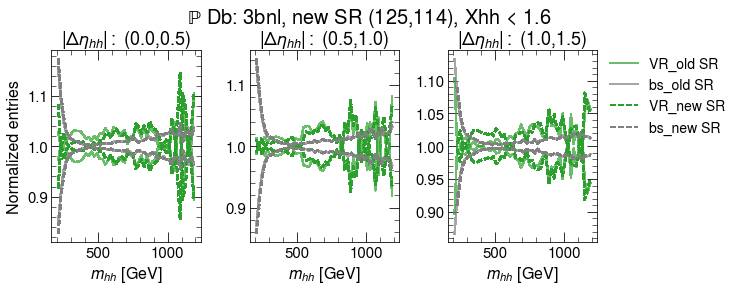

In [143]:
lw = 1.5

for tag,color,sr,Xhh_cut in zip(['4b','3b1l','3bnl'],['C0','C1','C2'],
                                [(125,116),(125,114),(125,114)],
                                [1.5,1.6,1.6]):

    fig,axes = plt.subplots(1,neta_bins,figsize=(3.5*neta_bins,4))
    for sid,ls,alpha in zip(['_old','_new'],['-','--'],[.7,1]): 
    
    
        err, dbs = errs2d[f'{tag}_vr{sid}'], errs2d[f'{tag}_bs{sid}']

    
        for ax,ei,bi,emin,emax in zip(axes,err.T,dbs.T,ey[:-1],ey[1:]):

            ax.plot(xx,ei,color,ls=ls,lw=lw,alpha=alpha,label=f'VR{sid} SR')
            ax.plot(xx,2-ei,color,ls=ls,lw=lw,alpha=alpha)


            ax.plot(xx,1-bi,'grey',ls=ls,lw=lw,alpha=alpha,label=f'bs{sid} SR')
            ax.plot(xx,1+bi,'grey',ls=ls,lw=lw,alpha=alpha)
            
            if ls == '-':
                ax.set_xlabel('$m_{hh}$ [GeV]',fontsize=16)
                ax.set_title('$|\Delta \eta_{hh}|: $ '+f'({emin:.1f},{emax:.1f})')


    axes[0].set_ylabel('Normalized entries',fontsize=16)
    axes[-1].legend(bbox_to_anchor=(1,1.03))
    
    fig.suptitle(f'{psymb} Db: {tag}, new SR ({sr[0]:.0f},{sr[1]:.0f}), Xhh < {Xhh_cut:.1f}',fontsize=20,va='center')
    plt.tight_layout()

    plt.show()

**Lastly:** Check $|\Delta \eta_{hh}|$ modelling in the new + old VRs.

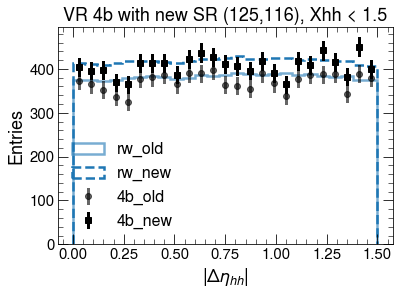

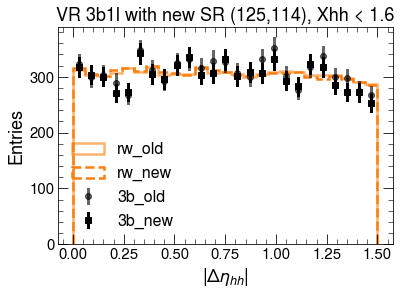

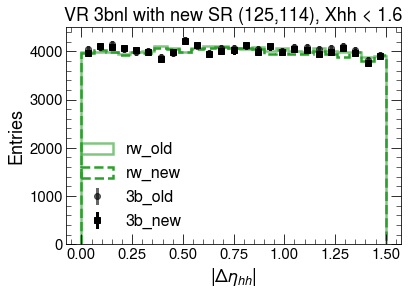

In [157]:
for bdf,f,ntag,tag,color,sr_new,opt_cut in zip([bdf_4b,bdf_3b1l,bdf_3bnl], [f_4b,f_3b1l,f_3bnl],
                                               [4,3,3],['4b','3b1l','3bnl'], ['C0','C1','C2'],
                                               [(125,116),(125,114),(125,114)], [1.5,1.6,1.6]):
    
    
    plt.figure()
    
    for sr,Xhh_cut,sid,ls,alpha,m in zip([(120,110),sr_new],[1.6,opt_cut],['_old','_new'],
                                         ['-','--'],[.6,1],['o','s']):
    
        x,y = sr
        Xhh = f'Xhh_{x:.0f}_{y:.0f}'

        bmask = (bdf.kinematic_region<=1) & (bdf[Xhh]> Xhh_cut) & (bdf.X_wt > 1.5) 

        b_rw,ee,_ = plt.hist(bdf.loc[bmask & (bdf.ntag_pag == 2),'abs_deta_hh'], 
                             25, (0,1.5), histtype='step',lw=2.5,
                             color=color,label=f'rw{sid}',alpha=alpha,ls=ls,
                             weights=bdf.loc[bmask & (bdf.ntag_pag == 2),w_2b])
        
        n = np.histogram(bdf.loc[bmask & (bdf.ntag_pag == ntag),'abs_deta_hh'], 25, (0,1.5))[0]
        ex = 0.5 * (ee[1:]+ee[:-1])
        plt.errorbar(ex,n,np.sqrt(n),lw=0,elinewidth=2.5,color='k',label=f'{ntag}b{sid}',
                     alpha=alpha,marker=m)

    plt.xlabel('$|\Delta \eta_{hh}|$',fontsize=18)
    plt.ylabel('Entries',fontsize=18)
    plt.legend(fontsize=16)
    plt.title(f'VR {tag} with new SR ({sr[0]:.0f},{sr[1]:.0f}), Xhh < {Xhh_cut:.1f}')

Gosh - I'm *not* sure what to make of this...

### Category agreement

Since the reweighting was derived inclusively, Sean said it's also important to check the agreement for the separate $\Delta \eta_{hh}$ bins.

**Check the $m_{hh}$ agreement in the VR in the 3 deta bins**

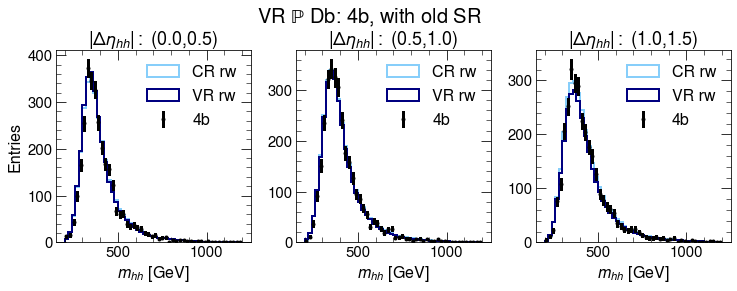

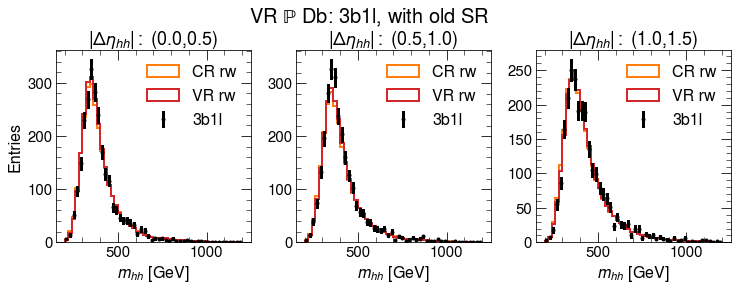

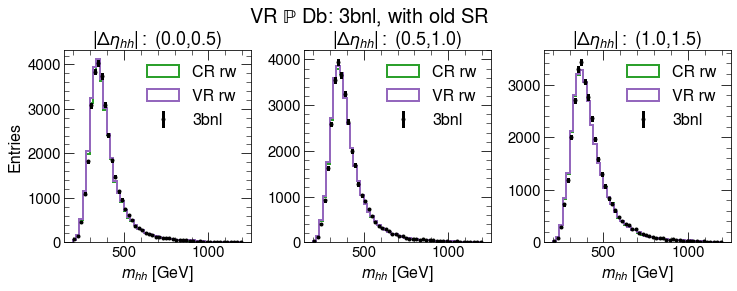

In [188]:
lw = 1.5

for bdf,tag,ntag,c0,c1 in zip([bdf_4b,bdf_3b1l,bdf_3bnl],['4b','3b1l','3bnl'],[4,3,3],
                              ['lightskyblue','C1','C2'], ['navy','C3','C4'],):

    fig,axes = plt.subplots(1,neta_bins,figsize=(3.5*neta_bins,4))

    bmask = (bdf.kinematic_region==1) & (bdf.X_wt > 1.5)

    for ax,emin,emax in zip(axes,ey[:-1],ey[1:]):

        m_cut = bmask & (bdf.abs_deta_hh > emin) & (bdf.abs_deta_hh < emax)
        b = ax.hist(bdf.loc[m_cut & (bdf.ntag_pag==2),'m_hh'].values, nb,r, 
                     histtype='step',color=c0,lw=2,label='CR rw',
                     weights=bdf.loc[m_cut & (bdf.ntag_pag==2),w_2b])[0]

        b = ax.hist(bdf.loc[m_cut & (bdf.ntag_pag==2),'m_hh'].values, nb,r, 
                     histtype='step',color=c1,lw=2,label='VR rw',
                     weights=bdf.loc[m_cut & (bdf.ntag_pag==2),w_2b_VR])[0]
        
        n = np.histogram(bdf.loc[m_cut & (bdf.ntag_pag == ntag),'m_hh'], nb, r)[0]
        
        ax.errorbar(xx,n,np.sqrt(n),lw=0,elinewidth=2.5,color='k',label=tag,
                     alpha=alpha,marker='.')
        
        ax.set_xlabel('$m_{hh}$ [GeV]',fontsize=16)
        ax.set_title('$|\Delta \eta_{hh}|: $ '+f'({emin:.1f},{emax:.1f})')
        ax.legend(fontsize=16)

    axes[0].set_ylabel('Entries',fontsize=16)
    
    
    fig.suptitle(f'VR {psymb} Db: {tag}, with old SR',fontsize=20,va='center')
    plt.tight_layout()

    plt.show()

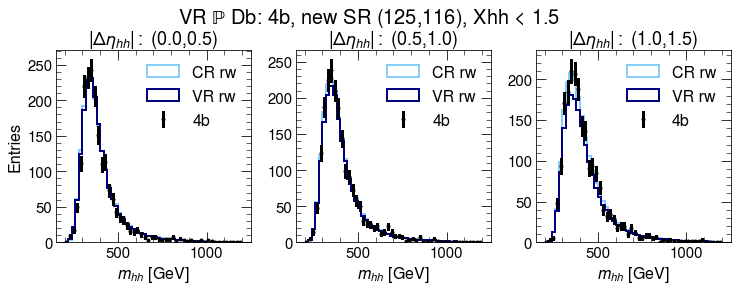

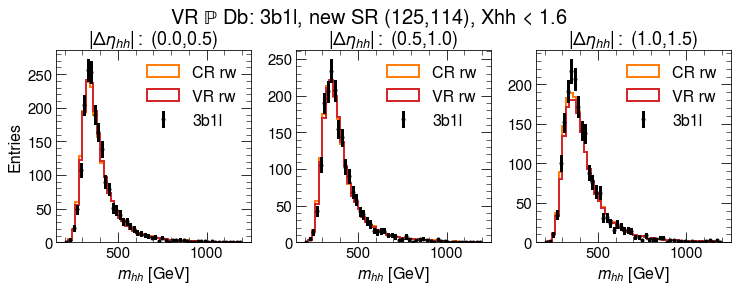

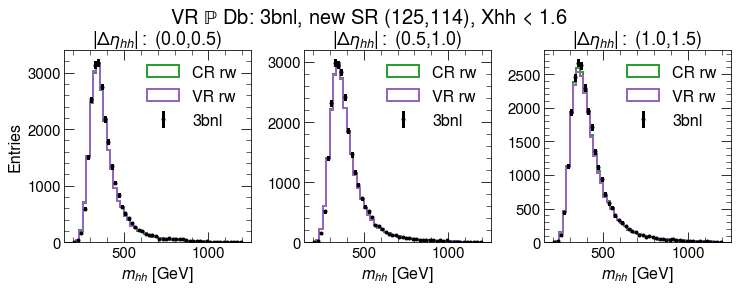

In [185]:
for bdf,tag,ntag,c0,c1,sr,Xhh_cut in zip([bdf_4b,bdf_3b1l,bdf_3bnl],['4b','3b1l','3bnl'],[4,3,3],
                                         ['lightskyblue','C1','C2'], ['navy','C3','C4'], 
                                         [(125,116),(125,114),(125,114)], [1.5,1.6,1.6]):

    fig,axes = plt.subplots(1,neta_bins,figsize=(3.5*neta_bins,4))

    Xhh = f'Xhh_{sr[0]:.0f}_{sr[1]:.0f}'
    bmask = (bdf.kinematic_region<=1) & (bdf[Xhh] < Xhh_cut) & (bdf.X_wt > 1.5)

    for ax,emin,emax in zip(axes,ey[:-1],ey[1:]):

        m_cut = bmask & (bdf.abs_deta_hh > emin) & (bdf.abs_deta_hh < emax)
        
        b = ax.hist(bdf.loc[m_cut & (bdf.ntag_pag==2),'m_hh'].values, nb,r, 
                     histtype='step',color=c0,lw=2,label='CR rw',
                     weights=bdf.loc[m_cut & (bdf.ntag_pag==2),w_2b])[0]

        b = ax.hist(bdf.loc[m_cut & (bdf.ntag_pag==2),'m_hh'].values, nb,r, 
                     histtype='step',color=c1,lw=2,label='VR rw',
                     weights=bdf.loc[m_cut & (bdf.ntag_pag==2),w_2b_VR])[0]
        
        n = np.histogram(bdf.loc[m_cut & (bdf.ntag_pag == ntag),'m_hh'], nb, r)[0]
        
        ax.errorbar(xx,n,np.sqrt(n),lw=0,elinewidth=2.5,color='k',label=tag,
                     alpha=alpha,marker='.')
        
        ax.set_xlabel('$m_{hh}$ [GeV]',fontsize=16)
        ax.set_title('$|\Delta \eta_{hh}|: $ '+f'({emin:.1f},{emax:.1f})')
        ax.legend(fontsize=16)

    axes[0].set_ylabel('Entries',fontsize=16)
    #axes[-1].legend(bbox_to_anchor=(1,1.03))
    
    fig.suptitle(f'VR {psymb} Db: {tag}, new SR ({sr[0]:.0f},{sr[1]:.0f}), Xhh < {Xhh_cut:.1f}',fontsize=20,va='center')
    plt.tight_layout()

    plt.show()

**Check the $m_{hh}$ agreement in the CR in the 3 deta bins**

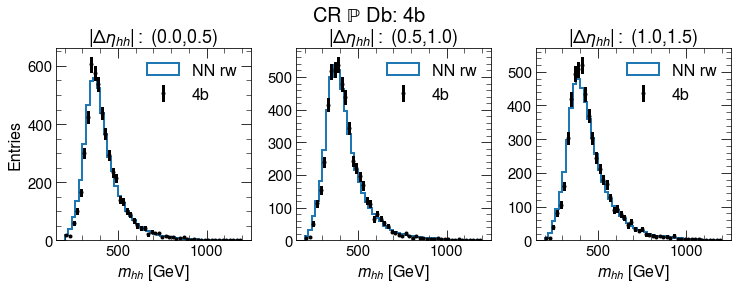

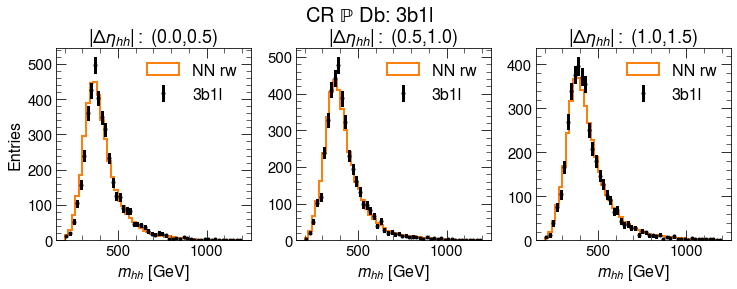

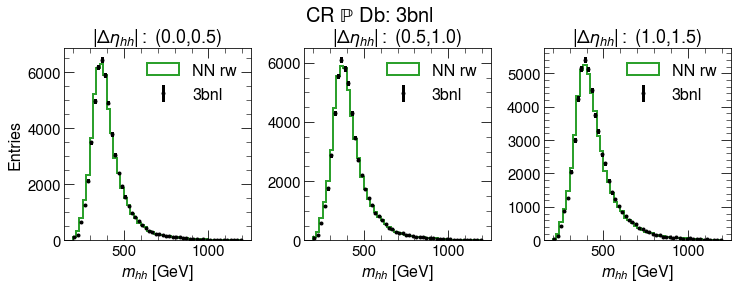

In [176]:
lw = 1.5

for bdf,tag,ntag,color in zip([bdf_4b,bdf_3b1l,bdf_3bnl],['4b','3b1l','3bnl'],[4,3,3],['C0','C1','C2']):

    fig,axes = plt.subplots(1,neta_bins,figsize=(3.5*neta_bins,4))

    bmask = (bdf.kinematic_region==2) & (bdf.X_wt > 1.5)

    for ax,emin,emax in zip(axes,ey[:-1],ey[1:]):

        m_cut = bmask & (bdf.abs_deta_hh > emin) & (bdf.abs_deta_hh < emax)
        b = ax.hist(bdf.loc[m_cut & (bdf.ntag_pag==2),'m_hh'].values, nb,r, 
                     histtype='step',color=color,lw=2,label='NN rw',
                     weights=bdf.loc[m_cut & (bdf.ntag_pag==2),w_2b])[0]

        n = np.histogram(bdf.loc[m_cut & (bdf.ntag_pag == ntag),'m_hh'], nb, r)[0]
        
        ax.errorbar(xx,n,np.sqrt(n),lw=0,elinewidth=2.5,color='k',label=tag,
                     alpha=alpha,marker='.')
        
        ax.set_xlabel('$m_{hh}$ [GeV]',fontsize=16)
        ax.set_title('$|\Delta \eta_{hh}|: $ '+f'({emin:.1f},{emax:.1f})')
        ax.legend(fontsize=16)

    axes[0].set_ylabel('Entries',fontsize=16)
    #axes[-1].legend(bbox_to_anchor=(1,1.03))
    
    fig.suptitle(f'CR {psymb} Db: {tag}',fontsize=20,va='center')
    plt.tight_layout()

    plt.show()

**Last "putting the pieces together" check:** Combine w/ my optimized MDpT?